### Get ready

In [2]:
#### Install
# conda install -c conda-forge -c ets skll
# conda install -c conda-forge scikit-optimize
# conda install -c conda-forge tqdm 
# conda install -c conda-forge eli5
# conda install -c conda-forge graphviz 
# conda install -c conda-forge pydotplus
# pip install treeinterpreter
# pip install pycebox
# conda install -c conda-forge pdpbox 
# conda install -c conda-forge xgboost <-- failed for Shinhan, worked for Serena 
# pip install xgboost <-- failed for Serena, worked for Shinhan
# conda install -c conda-forge lime 
# conda install -c conda-forge shap

# **Interpretable Machine Learning with Python**
[Savvas Tjortjoglou, Thu 26 April 2018](http://savvastjortjoglou.com/intrepretable-machine-learning-nfl-combine.html#PDP-and-ICE-plots)

## Build model

### Import necessary modules

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [4]:
from sklearn.impute import SimpleImputer # Change from the website
from sklearn.model_selection import  cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Note: in the website it said spearman, which does not work
from skll.metrics import spearmanr

In [6]:
# Note: The package is called scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [7]:
# setting up the styling for the plots in this notebook
sns.set(style="white", palette="colorblind", font_scale=1.2, 
        rc={"figure.figsize":(8,6)})

### Load data

In [8]:
# read in our data
data_df = pd.read_csv('combine_data_since_2000_PROCESSED_2018-04-26.csv')

# only get players that have been in the league for 3 years
data_df2 = data_df.loc[data_df.Year <= 2015].copy()
data_df2.head()

,Player,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year,Pfr_ID,AV,Team,Round,Pick
0,John Abraham,OLB,76,252,4.55,NaN,NaN,NaN,NaN,NaN,2000,AbraJo00,26.0,New York Jets,1.0,13.0
1,Shaun Alexander,RB,72,218,4.58,NaN,NaN,NaN,NaN,NaN,2000,AlexSh00,26.0,Seattle Seahawks,1.0,19.0
2,Darnell Alford,OT,76,334,5.56,25.0,23.0,94.0,8.48,4.98,2000,AlfoDa20,0.0,Kansas City Chiefs,6.0,188.0
3,Kyle Allamon,TE,74,253,4.97,29.0,NaN,104.0,7.29,4.49,2000,NaN,0.0,NaN,NaN,NaN
4,Rashard Anderson,CB,74,206,4.55,34.0,NaN,123.0,7.18,4.15,2000,AndeRa21,6.0,Carolina Panthers,1.0,23.0


In [9]:
# calculate the player AV (Approximate Value, this is a sports thing) percentiles by position
data_df2['AV_pctile'] = (data_df2.groupby('Pos').AV.rank(pct=True,
                                                         method='min', 
                                                         ascending=True))
data_df2.head()

,Player,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year,Pfr_ID,AV,Team,Round,Pick,AV_pctile
0,John Abraham,OLB,76,252,4.55,NaN,NaN,NaN,NaN,NaN,2000,AbraJo00,26.0,New York Jets,1.0,13.0,0.951482
1,Shaun Alexander,RB,72,218,4.58,NaN,NaN,NaN,NaN,NaN,2000,AlexSh00,26.0,Seattle Seahawks,1.0,19.0,0.936123
2,Darnell Alford,OT,76,334,5.56,25.0,23.0,94.0,8.48,4.98,2000,AlfoDa20,0.0,Kansas City Chiefs,6.0,188.0,0.002611
3,Kyle Allamon,TE,74,253,4.97,29.0,NaN,104.0,7.29,4.49,2000,NaN,0.0,NaN,NaN,NaN,0.003509
4,Rashard Anderson,CB,74,206,4.55,34.0,NaN,123.0,7.18,4.15,2000,AndeRa21,6.0,Carolina Panthers,1.0,23.0,0.630058


In [10]:
# Get the data for the (football) position we want, in this case it's DE
pos_df = data_df2.loc[data_df2.Pos=='DE'].copy().reset_index(drop=True)
pos_df.head()

,Player,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year,Pfr_ID,AV,Team,Round,Pick,AV_pctile
0,Michael Boireau,DE,76,274,5.09,29.0,26.0,105.0,7.68,4.49,2000,NaN,0.0,NaN,NaN,NaN,0.002427
1,Courtney Brown,DE,77,269,4.78,NaN,NaN,NaN,NaN,NaN,2000,BrowCo22,16.0,Cleveland Browns,1.0,1.0,0.871359
2,Lamont Bryant,DE,75,260,4.91,NaN,17.0,NaN,NaN,NaN,2000,BryaLa00,0.0,NaN,NaN,NaN,0.002427
3,Leonardo Carson,DE,73,283,5.06,28.0,22.0,106.0,7.82,4.75,2000,CarsLe20,10.0,San Diego Chargers,4.0,113.0,0.730583
4,Rameel Connor,DE,75,276,5.00,35.5,25.0,121.0,7.65,4.45,2000,NaN,0.0,NaN,NaN,NaN,0.002427


### Create training and testing data

In [11]:
# Split the data into train and test sets
train_df = pos_df.loc[pos_df.Year <= 2011]
test_df  = pos_df.loc[pos_df.Year.isin([2012, 2013, 2014, 2015])]

### Build Random Forest model

In [12]:
# Get list of feature names
features = ['Forty', 'Wt', 'Ht', 'Vertical', 'BenchReps', 'BroadJump', 'Cone', 'Shuttle']
# define what we want to predict (label)
target   = 'AV_pctile'

# separate features (x) and labels (y)
X = train_df[features].values
y = train_df[target].values

In [13]:
# get a general idea of what these look like
X[:5,:]

array([[  5.09, 274.  ,  76.  ,  29.  ,  26.  , 105.  ,   7.68,   4.49],
       [  4.78, 269.  ,  77.  ,    nan,    nan,    nan,    nan,    nan],
       [  4.91, 260.  ,  75.  ,    nan,  17.  ,    nan,    nan,    nan],
       [  5.06, 283.  ,  73.  ,  28.  ,  22.  , 106.  ,   7.82,   4.75],
       [  5.  , 276.  ,  75.  ,  35.5 ,  25.  , 121.  ,   7.65,   4.45]])

In [14]:
y[:5]

array([0.00242718, 0.87135922, 0.00242718, 0.73058252, 0.00242718])

Pipeline: 
* See https://scikit-learn.org/stable/modules/compose.html#pipeline
* Transformers are usually combined with classifiers, regressors or other estimators to build a composite estimator. Pipeline is often used in combination with FeatureUnion which concatenates the output of transformers into a composite feature space. 
* Parameters - A list of (key, value) pairs, where:
  * the key is a string containing the name you want to give this step and
  * value is an estimator object:


In [15]:
# make our pipeline for this model

RANDOM_STATE = 420 # From Scikit-optimize docs: "Pseudo random number 
# generator state used for random uniform sampling from lists of possible values instead of scipy.stats distributions"

pipe = Pipeline([("imputer", SimpleImputer()), # Class Imputer is deprecated, use SimpleImputer instead.
                 ("estimator", RandomForestRegressor(random_state=RANDOM_STATE))])

### Model tuning

In [16]:
# We use spearman's rank correlation as the scoring metric since
# we are concerned with ranking the players

# Note that Sklearn.metrics does not have spearman.
# And skll's spearman function is now called spearmanr, and it return a tuple of two values,
# But the fit function thrown an error because it is expecting just one

# Try to make a custom one
# See: 3.3.1.2 in https://scikit-learn.org/stable/modules/model_evaluation.html
# from scipy.stats import spearmanr

# def spearman_rho_only(a,b):
#     return spearmanr(a,b).correlation

# spearman_score = make_scorer(spearman_rho_only)

# Still got NAN error when fit function is called below. Give up on this.

Grid search:
* see: http://blairhudson.com/blog/posts/optimising-hyper-parameters-efficiently-with-scikit-optimize/
* he hyperparamters to search over, including different imputation strategies

In [17]:
# define the parameter space over which to search 
rf_param_space = {
    'imputer__strategy': Categorical(['mean', 'median', 'most_frequent']),
    'estimator__max_features': Integer(1, 8),
    'estimator__n_estimators': Integer(50, 500), 
    'estimator__min_samples_split': Integer(2, 200),
}

In [18]:
# since spearman didn't work, use r2 to define a scorer to evaluate model performance
from sklearn.metrics import r2_score  
r2 = make_scorer(r2_score)

BayesSearchCV uses Bayesian Optimization where a predictive model referred to as “surrogate” is used to model the search space and utilized to arrive at good parameter values combination as soon as possible.

In [19]:
# create our random search object using the Sklearn-Optimize package
# Doc: https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV

N_JOBS=8


search = BayesSearchCV(pipe,                      # Estimator
                       rf_param_space,            # Search_space
                       cv=10,                     # Cross-validation generator or an iterable
                       n_jobs=N_JOBS,             # Num of job run in parallel 
                       verbose=0, 
                       error_score=-9999,         # Value to assign to the score if an error occurs in estimator fitting.
                       scoring=r2,                # Loss function
                       random_state=RANDOM_STATE, # For random uniform sampling
                       return_train_score=True,   # The cv_results_ attribute will include training scores.
                       n_iter=10)                 # Number of parameter settings that are sampled.

# n_iter is set very low which is unrealistic, for running the whole thing faster. 

### What is the output of `BayesSearchCV( )`?
A class instance with a set of attributes and a set of methods. The attributes are the hyperparameters that were chosen in the search, such as cv_results_ and best_score_. <br>

Class methods used in this tutorial (from docs): 
1. `fit(self,X,y,groups,callback)` : "Run fit on the estimator with randomly drawn parameters." Only X and y are required, can provide group labels used while splitting the dataset into train/test. 
2. `predict(self,X)` : "Call predict on the estimator with the best found parameters" --> predicts labels/values for the provided instances.

In [20]:
## Using spearman_score, got
## --> ValueError: Input contains NaN, go back to use r2

# fit the model (a.k.a. train the model)
search.fit(X, y) 

BayesSearchCV(cv=10, error_score=-9999,
              estimator=Pipeline(memory=None,
                                 steps=[('imputer',
                                         SimpleImputer(add_indicator=False,
                                                       copy=True,
                                                       fill_value=None,
                                                       missing_values=nan,
                                                       strategy='mean',
                                                       verbose=0)),
                                        ('estimator',
                                         RandomForestRegressor(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               criterion='mse',
                                                               max_depth=None,
                                                               

In [21]:
# view best model parameters (object attribute)
search.best_params_

OrderedDict([('estimator__max_features', 6),
             ('estimator__min_samples_split', 42),
             ('estimator__n_estimators', 375),
             ('imputer__strategy', 'most_frequent')])

In [22]:
# view score of best_estimator on the left out data (i.e. how did the model perform?)
# this is the score using the performance metric (scorer) that we provided to BayesSearchCV( ), so here is r2
# is this the best score of the cross validation splits, when the model is applied to the 10% that was left out (but that the model has already seen)?
search.best_score_

0.1251275916733097

In [23]:
# View split training and testing scores
searchResults = pd.DataFrame(search.cv_results_)
searchResults.head()

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,...,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_features,param_estimator__min_samples_split,param_estimator__n_estimators,param_imputer__strategy,params,rank_train_score
0,-0.054400,0.102235,0.101677,0.034888,0.054914,0.031297,0.135804,0.085493,0.092222,0.111375,...,2.617026,0.866432,0.157017,0.069138,5,142,287,median,"{'estimator__max_features': 5, 'estimator__min...",8
1,-0.075334,0.181726,0.202825,0.058129,0.092091,0.000007,0.195300,0.134274,0.144350,0.158326,...,0.803949,0.229152,0.034584,0.015328,7,93,137,mean,"{'estimator__max_features': 7, 'estimator__min...",5
2,-0.059033,0.124095,0.165521,0.064966,0.095709,-0.004723,0.130411,0.130675,0.116789,0.122949,...,2.017526,0.553891,0.092944,0.050526,7,117,231,most_frequent,"{'estimator__max_features': 7, 'estimator__min...",6
3,-0.060937,0.233634,0.284892,0.048825,0.094346,-0.006292,0.241879,0.111467,0.132016,0.176489,...,3.123110,1.106811,0.116497,0.044132,6,42,375,most_frequent,"{'estimator__max_features': 6, 'estimator__min...",1
4,-0.057614,0.110046,0.130069,0.048667,0.067302,0.022258,0.151105,0.092738,0.092853,0.114085,...,1.494522,0.535385,0.058252,0.021011,5,132,217,median,"{'estimator__max_features': 5, 'estimator__min...",7


In [24]:
# now apply the model to the test data

# define test set data
X_test = test_df[features].values
y_test = test_df[target].values

# apply the model
y_pred = search.predict(X_test)

model_test_score = r2(search, X_test, y_test) 
model_test_score # why is this negative? Does this mean the model is really bad? Why is it so much worse on the test data?

-0.031092927334830156

In [25]:
# test the correlation between ground truth and predicted values with pearson correlation coefficient (PCC)
from scipy.stats import pearsonr
pearsonr(y_test, y_pred) # returns (r, two-tailed p-value)

(0.23099783203501978, 0.02355094844797427)

In [26]:
# create percentiles for nfl draft picks (ranking the players based on the AV we predicted)
# Lower numerical picks (e.g. 1, 2, 3) are ranked closer to 1
# Higher numerical picks (e.g. 180, 200, etc) are ranked closer to 0 
draft_pick_pctile = test_df.Pick.rank(pct=True,
                                      method='min', 
                                      ascending=False, 
                                      na_option='top')
# how does real value of AV correlate with real percentile? (not super interesting)
pearsonr(y_test, draft_pick_pctile) # here it would be ideal to use spearman's rank, but their code is too old and not compatible

(0.6351055580150402, 3.659581469708443e-12)

## Feature importance

### Mean decrease impurity 
This section from the original tutorial, for a more indepth explanation with better resources please see my notes.<br>

Definition - Gini impurity
* https://en.wikipedia.org/wiki/Decision_tree_learning
  * A set of items with $J$ classes,
  * Suppose $i \in {1, 2, ..., J}$, 
  * Let $p_i$  be the faction of items labeled with class $i$ in the set

$$I_G(p) = \sum_{i=1}^J p_i \sum_{k \ne i} p_k = \sum_{i=1}^J p_i(1-p_i)$$

Define: mean decrease impurity = Gini importance
* https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3
* The total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble.


The feature importances are a reflection of how well a feature reduces some criterion
* Regression: mean square error
* Tree-ensemble: mean decrease impurity or gini importance

In [27]:
# The pipline has 1 imputer and  1 estimator step

# reminder: search is a BayesSearchCV object, the function used the pipeline object to make this object
# self.best_estiamtor_ is: Estimator that was chosen by the search, 
# i.e. estimator which gave highest score (or smallest loss if specified) on the left out data.

imputer   = search.best_estimator_.named_steps['imputer'] # the best estimator is the Pipeline object (I think) with the best parameter values 
estimator = search.best_estimator_.named_steps['estimator'] # named steps is a dict, keys are names and values are objects, they are the steps we included in our Pipeline object

estimator.feature_importances_

array([0.29335981, 0.31970761, 0.02847384, 0.05192288, 0.07050175,
       0.07827273, 0.08667251, 0.07108886])

The original tutorial just had here: "Get feature important and stdev, the later may not be trustworth due to normality assumption"

### Descision path importance (eli5)
ELI5 is a Python package which helps to debug machine learning classifiers and explain their predictions. [docs](https://readthedocs.org/projects/eli5/downloads/pdf/latest/) <br>

From the docs: "Feature weights are calculated by following decision paths in trees of an ensemble (or a single tree for DecisionTreeClassifier). Each node of the tree has an output score, and contribution of a feature on the decision path is how much the score changes from parent to child. Weights of all features sum to the output score or proba of the estimator." <br>

The docs link to [this page](http://blog.datadive.net/interpreting-random-forests/). This post describes a method to decompose individual predictions, by representing them as the sum of the initial mean of the dataset and the contributions (the difference between the mean at the current node and the mean at the previous node) of each feature along the path. However, it does not explain how to make one feature weight across all paths and trees in a RF model, so I am totally unsure of what the calculation is within this package. Specifically, I have no idea what they mean by, "Weights of all features sum to the output score or proba of the estimator.", and have no idea how they calculated an overall feature weight across multiple paths. I have been unable to find any resources explaining this method even though there are two packages that do this. 

------------------------------
**Interpretation of specific functions** <br>

What does `eli5.explain_weights_df( )` do? `eli5.explain_weights_df( )` passes all arguments to `eli5.explain_weights( )`. <br>

What does `eli5.explain_weights( )` do? Docs say: "`explain_weights()` is not doing any work itself, it dispatches to a concrete implementation based on
estimator type." It returns an `Explanation` instance. This is then made into a DataFrame <br>

What are the attributes of an `Explanation` instance? This is all that's in the docs: <br>
"`class Explanation(estimator, description=None, error=None, method=None, is_regression=False,
targets=None, feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)` <br>
An explanation for classifier or regressor, it can either explain weights or a single prediction." <br>

I would think the attributes of the object are the columns in the resulting df, so the attributes must be features, weights, and standard deviations. 



In the following cell there are some FutureWarnings from scikit-learn, learn how to deal with them [here](https://machinelearningmastery.com/how-to-fix-futurewarning-messages-in-scikit-learn/)

In [28]:
import eli5 # ELI5 is a Python package which helps to debug machine learning classifiers and explain their predictions.
# docs: https://eli5.readthedocs.io/en/latest/overview.html

feat_imp_df = eli5.explain_weights_df(estimator, feature_names=features) 
feat_imp_df

/anaconda3/envs/ML_interpretability/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/anaconda3/envs/ML_interpretability/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


,feature,weight,std
0,Wt,0.319708,0.091033
1,Forty,0.293360,0.095883
2,Cone,0.086673,0.083762
3,BroadJump,0.078273,0.082019
4,Shuttle,0.071089,0.074630
5,BenchReps,0.070502,0.073576
6,Vertical,0.051923,0.065428
7,Ht,0.028474,0.041770


The first FutureWarning is as follows: 
    
    /anaconda3/envs/ML_interpretability/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
    
This must be because explain_weights_df uses something from the scorer module and imports it this way. Okay to ignore this one for now, but if you are using this tutorial with 0.24 and this hasn't been fixed in eli5, this could be broken. <br>

The second warning is similar: 

    /anaconda3/envs/ML_interpretability/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

In [29]:
# tree.feature_importances_ is from scikit learn, so these are MDI importances 

# get the feature importances from each tree and then visualize the
# distributions as boxplots
all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in 
                                     estimator],
                               columns=features)

sns.boxplot(data=all_feat_imp_df).set(title='Feature Importance Distributions',
             ylabel='Importance')


[Text(0, 0.5, 'Importance'),
 Text(0.5, 1.0, 'Feature Importance Distributions')]

### Permutation importance
Also called mean decrease accuracy (MDA)
* Permute the values of each feature and measure how much that permutation negatively impacts the scoring metric

In [30]:
from eli5.sklearn import PermutationImportance
# we need to impute the data first before calculating permutation importance
train_X_imp = imputer.transform(X)
# set up the met-estimator to calculate permutation importance on our training
# data
perm_train = PermutationImportance(estimator, scoring=r2,
                                   n_iter=50, random_state=RANDOM_STATE)
# fit and see the permuation importances
perm_train.fit(train_X_imp, y)
eli5.explain_weights_df(perm_train, feature_names=features)

,feature,weight,std
0,Wt,0.303350,0.032250
1,Forty,0.237577,0.031657
2,Cone,0.040714,0.005697
3,Shuttle,0.036012,0.005826
4,BroadJump,0.032836,0.005403
5,BenchReps,0.029503,0.004742
6,Vertical,0.022869,0.003648
7,Ht,0.009884,0.001659


In [31]:
# plot the distributions
perm_train_feat_imp_df = pd.DataFrame(data=perm_train.results_,
                                      columns=features)
(sns.boxplot(data=perm_train_feat_imp_df)
        .set(title='Permutation Importance Distributions (training data)',
             ylabel='Importance'));

## Feature contributions

Question: how do features impact model predictions?
* $C_{f_n}$ : contribution of feature $n$
* $b$: bias, baseline, random guessed value

$$prediction = b + C_{f_1} + C_{f_2} +... + C_{f_n}$$

Tools:
* eli5
* treeinterpreter

### Get all trees with certain depth

In [32]:
from IPython.display import Image  
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from io import StringIO  

In [33]:
# source for plotting decision tree
# https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
# Get all trees of depth 2 in the random forest
# --> Well, in mine none is 2, so use 3
depths2 = [tree for tree in estimator.estimators_ if tree.tree_.max_depth==3]
len(depths2)

1

### Plot tree
For each node: 4 values
* Criterion for bifurcation
* mse: mean square error?
* Number of samples in the node
* Mean value for the response variable: here AV percentile

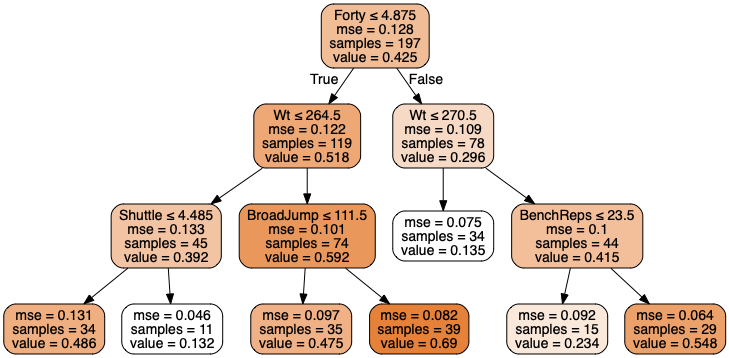

In [34]:
tree = depths2[0]
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, feature_names=features, 
                filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Feature contribution - global interpretation

Consider a player with Wt = 250, Forty = 4:
* Following the left most path with a final AV_percentile = 0.645

$$AV = bias + Wt + Forty$$

$$0.645 = 0.44 + (0.316 - 0.44) + (0.645 - 0.316) = 0.44 - 0.124 + 0.329$$

### Feature contribution - local interpretation for one instance

In [35]:
# simple exmaple of a player with a 4.6 Forty and a Wt of 260 lbs
# Note: all other feature values are at zero... why?? try another one below.
example = np.array([4.6, 260, 0, 0, 0, 0, 0, 0])
eli5.explain_prediction_df(tree, example, feature_names=features)

,target,feature,weight,value
0,y,<BIAS>,0.425364,1.0
1,y,Shuttle,0.093679,0.0
2,y,Forty,0.092510,4.6
3,y,Wt,-0.125777,260.0


In [36]:
example = np.array([4.6, 260, 20, 30, 20, 20, 20, 0])
eli5.explain_prediction_df(tree, example, feature_names=features)

,target,feature,weight,value
0,y,<BIAS>,0.425364,1.0
1,y,Shuttle,0.093679,0.0
2,y,Forty,0.092510,4.6
3,y,Wt,-0.125777,260.0


**Q: Why is it referred to as weight??**

In [37]:
# Predicted value based on the tree
tree.predict(example.reshape(1,-1))

array([0.4857767])

### Get feature contribution for each sample (instances)

In [38]:
from concurrent.futures import ProcessPoolExecutor

# Check out *args and **kwargs in python explained
# https://pythontips.com/2013/08/04/args-and-kwargs-in-python-explained/
def multiproc_iter_func(max_workers, an_iter, func, item_kwarg, **kwargs):
    """
    A helper functions that applies a function to each item in an iterable using
    multiple processes. 'item_kwarg' is the keyword argument for the item in the
    iterable that we pass to the function.
    """
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        future_results = [executor.submit(func, **{item_kwarg: item}, **kwargs)
                          for item in an_iter]
        results = [future.result() for future in future_results]
    return results

In [39]:
# Contibrutions for training set predictions
# construct a list of all contributions for the entire train set
train_expl_list = multiproc_iter_func(N_JOBS, train_X_imp, 
                                      eli5.explain_prediction_df, 'doc',
                                      estimator=estimator, 
                                      feature_names=features)

In [40]:
# concatenate them into 1 large dataframe, with the proper player name as an
# index
train_expl_df = pd.concat(train_expl_list, keys=train_df.Player, 
                          names=['Player'])

In [41]:
# take a look at a couple of players
train_expl_df.head(18)

target    feature    weight   value
Player                                               
Michael Boireau 0      y     <BIAS>  0.421845    1.00
                1      y         Wt  0.050429  274.00
                2      y  BenchReps  0.009301   26.00
                3      y         Ht -0.001152   76.00
                4      y   Vertical -0.002914   29.00
                5      y    Shuttle -0.006204    4.49
                6      y  BroadJump -0.011278  105.00
                7      y       Cone -0.019489    7.68
                8      y      Forty -0.110280    5.09
Courtney Brown  0      y     <BIAS>  0.421845    1.00
                1      y      Forty  0.023770    4.78
                2      y  BenchReps  0.014490   24.00
                3      y    Shuttle  0.009883    4.32
                4      y       Cone -0.003600    7.50
                5      y   Vertical -0.006819   33.00
                6      y         Ht -0.008398   77.00
                7      y  BroadJump -0.013140  111.00
                8      y         Wt -0.037293  269.00

### Look at contributions for the test set

In [42]:
# Contributions for test set predictions
# we need to impute the missing values in the test set
test_X_imp = imputer.transform(X_test)
# now repeat what we did with the training data on the test data
test_expl_list = multiproc_iter_func(N_JOBS, test_X_imp, 
                                     eli5.explain_prediction_df, 'doc', 
                                     estimator=estimator,
                                     feature_names=features)

test_expl_df = pd.concat(test_expl_list, keys=test_df.Player, 
                         names=['Player'])
test_expl_df.head(18)

target    feature    weight   value
Player                                               
Frank Alexander 0      y     <BIAS>  0.421845    1.00
                1      y      Forty  0.026198    4.80
                2      y  BenchReps  0.017135   24.00
                3      y         Wt  0.008046  270.00
                4      y    Shuttle  0.002937    4.32
                5      y       Cone -0.001353    7.50
                6      y         Ht -0.006382   76.00
                7      y   Vertical -0.006856   33.00
                8      y  BroadJump -0.012925  111.00
Jake Bequette   0      y     <BIAS>  0.421845    1.00
                1      y         Wt  0.061556  274.00
                2      y      Forty  0.042826    4.75
                3      y       Cone  0.042051    6.90
                4      y  BenchReps  0.013871   24.00
                5      y    Shuttle  0.012331    4.07
                6      y  BroadJump  0.007751  113.00
                7      y   Vertical -0.000525   34.00
                8      y         Ht -0.001877   77.00

In [43]:
# Double check that the sums of contributions equal the actual predictions
y_pred_sums = test_expl_df.groupby('Player').weight.sum()
np.allclose(y_pred, y_pred_sums)

True

## Plotting feature contributions

### Feature contribution distribution

In [44]:
# I"m creating one big dataframe that includes both train and test
# to plot them on same plot using seaborn's boxplot
train_expl_df.rename(columns={'weight': 'contribution'}, inplace=True)
test_expl_df.rename(columns={'weight': 'contribution'}, inplace=True)
train_expl_df['data'] = 'train'
test_expl_df['data'] = 'test'
train_test_expl_df = pd.concat([train_expl_df, test_expl_df])
sns.boxplot(x='feature', y='contribution', hue='data', order=features,
            data=train_test_expl_df.loc[train_test_expl_df.feature!=''],
            palette={'train': 'salmon', 
                     'test':'deepskyblue'})
plt.legend(loc=9)
plt.title('Distributions of Feature Contributions');

### Graunular view of the feature contribution distribution

In [45]:
from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [46]:
# a hacky function that plots a swarmplot along with a colorbar
# based off the code found here:
# https://stackoverflow.com/questions/40814612/map-data-points-to-colormap-with-seaborn-swarmplot
def swarmplot_with_cbar(cmap, cbar_label, *args, **kwargs):
    fig = plt.gcf()
    ax = sns.swarmplot(*args, **kwargs)
    # remove the legend, because we want to set a colorbar instead
    ax.legend().remove()
    ## create colorbar ##
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="3%", pad=0.05)
    fig.add_axes(ax_cb)
    cb = ColorbarBase(ax_cb, cmap=cmap, orientation='vertical')
    cb.set_label(cbar_label, labelpad=10)
    
    return fig

For training data

In [47]:
# min-max scaling of the feature values allows us to use a colorbar
# to indicate high or low feature values
train_scaled_feat_vals = (train_expl_df.groupby('feature')
                                       .value
                                       .transform(lambda x: x/x.max()))

train_expl_df['scaled_feat_vals'] = train_scaled_feat_vals

cmap = plt.get_cmap('viridis')
cbar_label = 'Feature Value %ile'

plt.title('Distribution of Feature Contributions (training data)')
swarmplot_with_cbar(cmap, cbar_label,  x='feature', y='contribution',
                    hue='scaled_feat_vals', palette='viridis', order=features,
                    data=train_expl_df.loc[train_expl_df.feature!='']);

For test data

In [48]:
test_scaled_feat_vals = (test_expl_df.groupby('feature')
                                      .value
                                      .transform(lambda x: x/x.max()))

test_expl_df['scaled_feat_vals'] = test_scaled_feat_vals

plt.title('Distribution of Feature Contributions (test data)')
swarmplot_with_cbar(cmap, cbar_label,  x='feature', y='contribution',
                    hue='scaled_feat_vals', palette='viridis', order=features,
                    data=test_expl_df.loc[test_expl_df.feature!='']);

/anaconda3/envs/ML_interpretability/lib/python3.8/site-packages/seaborn/categorical.py:403: UserWarning: Use the colorbar set_ticks() method instead.
  ax.set_xticks(np.arange(len(self.plot_data)))


### Relationship between feature contribution and values - scatter plot
* E.g. Forty value smaller, more positive contribution to AV percentile

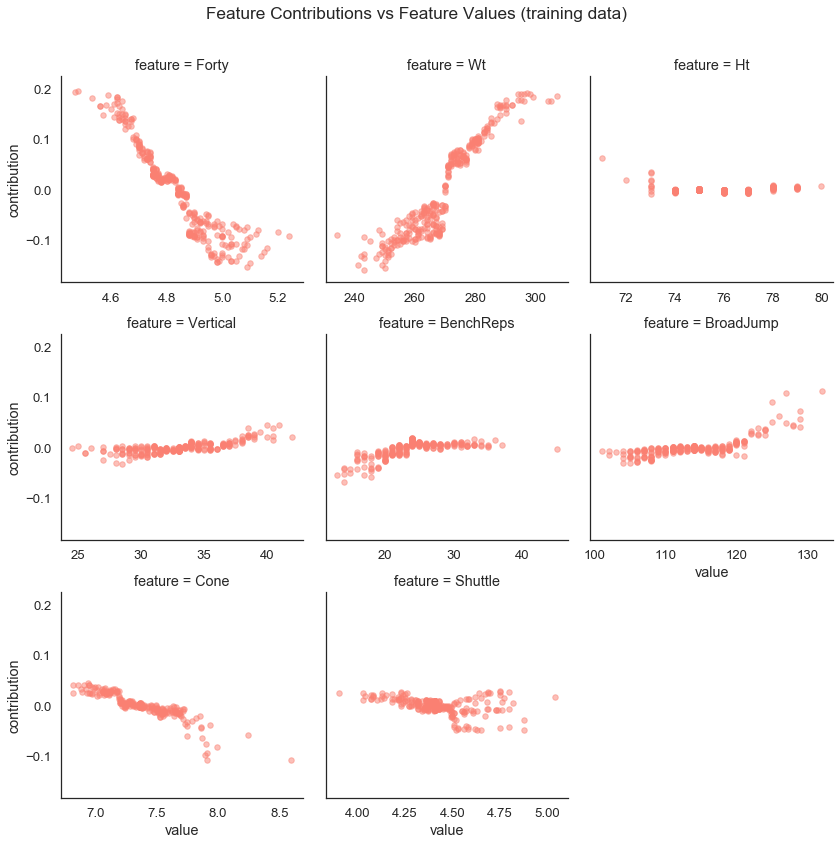

In [67]:
fg = sns.lmplot(x='value', y='contribution', col='feature',
                data=train_expl_df.loc[train_expl_df.feature!=''], 
                col_order=features, sharex=False, col_wrap=3, fit_reg=False,
                height=4, scatter_kws={'color':'salmon', 'alpha': 0.5, 's':30})
fg.fig.suptitle('Feature Contributions vs Feature Values (training data)')
fg.fig.subplots_adjust(top=0.90);

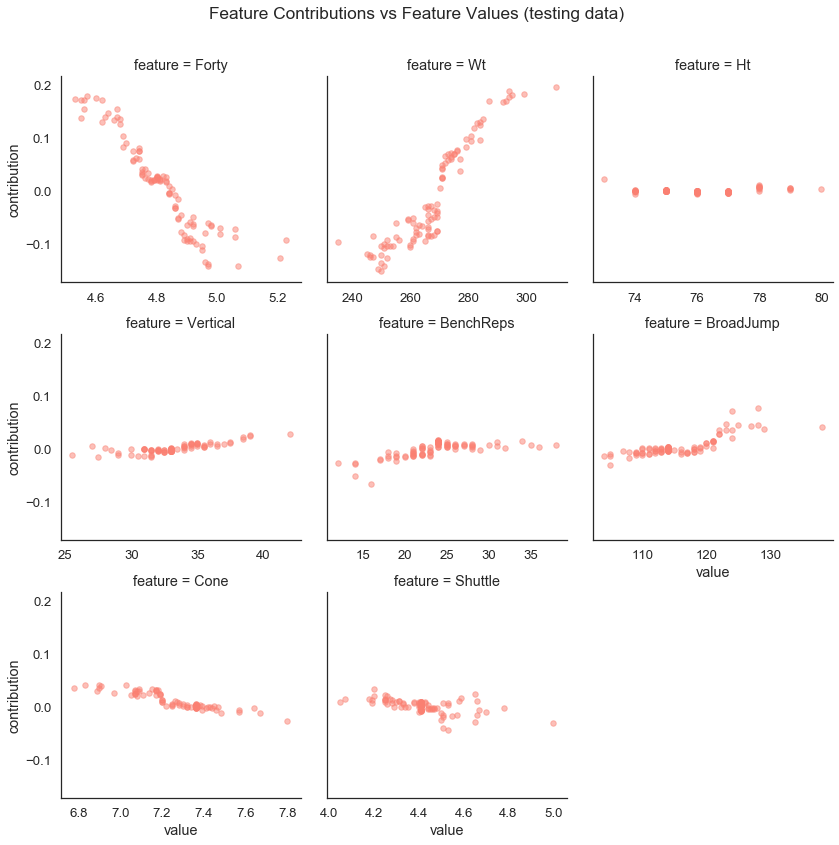

In [69]:
fg = sns.lmplot(x='value', y='contribution', col='feature',
                data=test_expl_df.loc[test_expl_df.feature!=''], 
                col_order=features, sharex=False, col_wrap=3, fit_reg=False, 
                height=4, scatter_kws={'color':'salmon', 'alpha': 0.5, 's':30})
fg.fig.suptitle('Feature Contributions vs Feature Values (testing data)')
fg.fig.subplots_adjust(top=0.90);

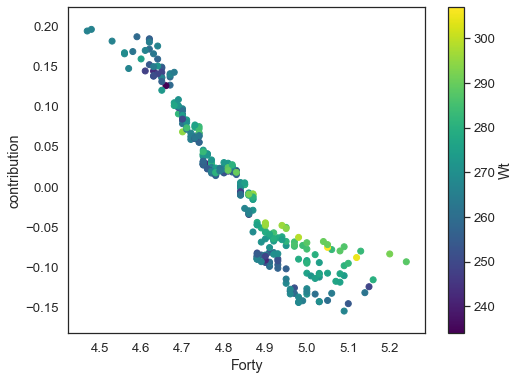

In [70]:
# before we actually plot anything we need to do a bit of data manipulation
# let's pivot the data and create a new dataframe where the columns are
# the feature contributions and each row is a player, with the player
# name as the index value
# here are different ways to pivot column values to columns
# https://stackoverflow.com/questions/26255671/pandas-column-values-to-columns
# based on running %%timeit, the groupby method was fastest 
train_contrib_df = (train_expl_df.groupby(['Player','feature'])
                                 .contribution
                                 .aggregate('first')
                                 .unstack())
# add in the feature values
train_feat_contrib_df = train_contrib_df.merge(train_df[['Player'] + features],
                                               how='left', left_index=True, 
                                               right_on='Player',
                                               suffixes=('_contrib', '_value'))
# now we can plot
plt.scatter(x='Forty_value', y='Forty_contrib', c='Wt_value', cmap=cmap,
            data=train_feat_contrib_df)
plt.xlabel('Forty')
plt.ylabel('contribution')
plt.colorbar(label='Wt');

In situation where there is higher variance, the feature may be interacting with another feature
* Here: Note at higher Forty time, heavier guys have higher contribution than lighter ones.

### Relationship between feature contribution and AV percentile - heatmap

In [71]:
def double_heatmap(data1, data2, cbar_label1, cbar_label2,
                   title='', subplot_top=0.86, cmap1='viridis', cmap2='magma', 
                   center1=0.5, center2=0, grid_height_ratios=[1,4],
                   figsize=(14,10)):
    # do the actual plotting
    # here we plot 2 seperate heatmaps one for the predictions and actual percentiles
    # the other for the contributions
    # the reason I chose to do this is because of the difference in magnitudes
    # between the percentiles and the contributions
    fig, (ax,ax2) = plt.subplots(nrows=2, figsize=figsize, 
                                 gridspec_kw={'height_ratios':grid_height_ratios})

    fig.suptitle(title)
    fig.subplots_adjust(hspace=0.02, top=subplot_top)

    # heatmap for actual and predicted percentiles
    sns.heatmap(data1, cmap="viridis", ax=ax, xticklabels=False, center=center1,
                cbar_kws={'location':'top', 
                          'use_gridspec':False, 
                          'pad':0.1,
                          'label': cbar_label1})
    ax.set_xlabel('')

    # heatmap of the feature contributions
    sns.heatmap(data2, ax=ax2, xticklabels=False, center=center2, cmap=cmap2,
                cbar_kws={'location':'bottom', 
                          'use_gridspec':False, 
                          'pad':0.07, 
                          'shrink':0.41,
                          'label': cbar_label2})
    ax2.set_ylabel('');
    return fig

In [72]:
# get the prediction and actual target values to plot
y_test_and_pred_df = pd.DataFrame(np.column_stack((y_test, y_pred)),
                                  index=test_df.Player,
                                  columns=['true_AV_pctile', 'pred_AV_pctile'])

# let's pivot the data such that the feature contributions are the columns
test_heatmap_df = (test_expl_df.groupby(['Player','feature'])
                               .contribution
                               .aggregate('first')
                               .unstack())

# there may be some NaNs if a feature did not contribute to a prediction, 
# so fill them in with 0s
test_heatmap_df = test_heatmap_df.fillna(0)

# merge our predictions with the the contributions
test_heatmap_df = test_heatmap_df.merge(y_test_and_pred_df, how='left',
                                        right_index=True, left_index=True)
# sort by predictions
test_heatmap_df.sort_values('pred_AV_pctile', ascending=True, inplace=True)

In [123]:
test_heatmap_df.head(2)

,<BIAS>,BenchReps,BroadJump,Cone,Forty,Ht,Shuttle,Vertical,Wt,true_AV_pctile,pred_AV_pctile
Player,,,,,,,,,,,
Brandon Jenkins,0.421925,-0.018269,-0.003275,-0.000689,-0.141831,-0.000447,0.000990,-0.000368,-0.107430,0.002427,0.150607
Tevin Mims,0.421925,-0.022448,-0.009122,-0.000212,-0.112532,-0.002744,0.000783,-0.014977,-0.102217,0.002427,0.158456


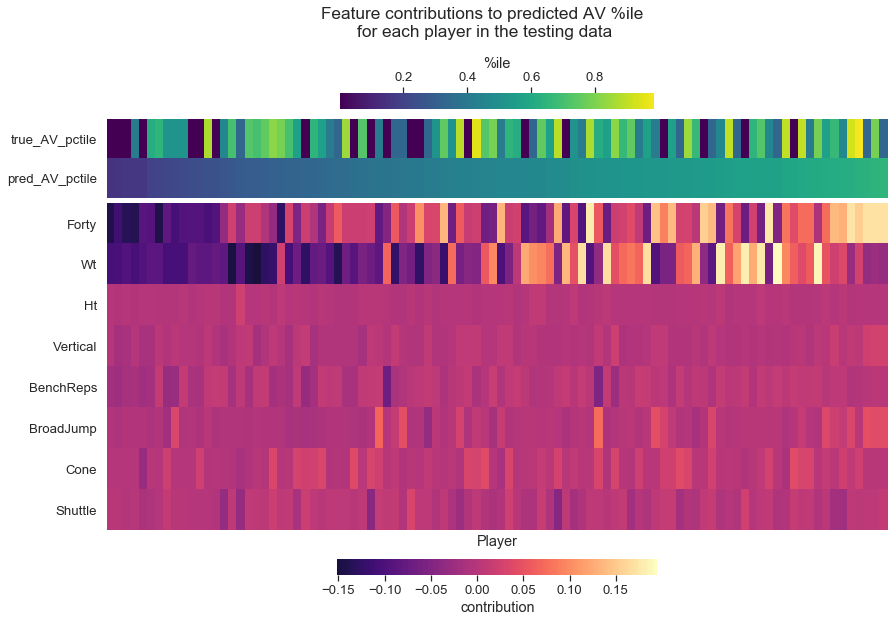

In [73]:
title = 'Feature contributions to predicted AV %ile \nfor each player in the testing data'
fig = double_heatmap(test_heatmap_df[['true_AV_pctile', 'pred_AV_pctile']].T,
                     test_heatmap_df[features].T, '%ile', 'contribution',
                     title=title)

## Joint feature distribution
Tree-ensemble capture interactions among features
* treeinterpreter
* xgbfir from XGBoost
* [Iterative Random Forest](https://arxiv.org/abs/1706.08457)


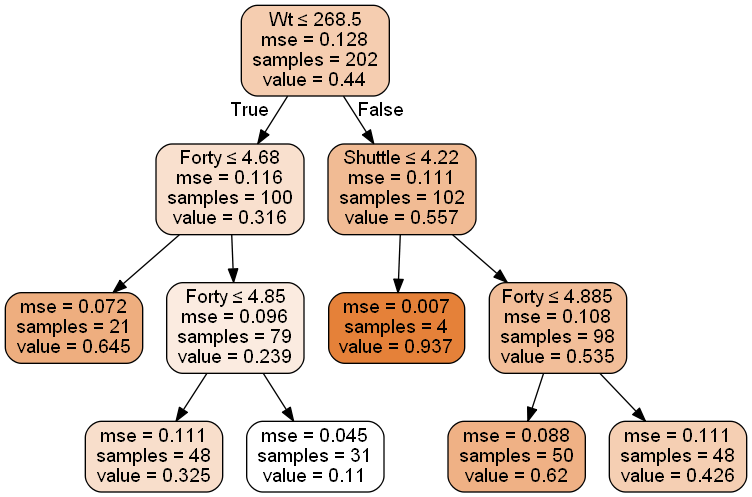

In [74]:
# a reminder of what the tree looks like
Image(graph.create_png())

### Interaction for one instance

In [75]:
import treeinterpreter.treeinterpreter as ti
# get the contributions for our simple player example
# who has a 4.6 forty and weighs 260 lbs
# joint_contribution=True gets the joint feature contributions
# when set to False it just returns the individual feature contributions
example_pred, example_bias, example_contrib = ti.predict(tree,
                                                         example.reshape(1, -1),
                                                         joint_contribution=True)
print(example_pred) 
print(example_bias)
print(example_contrib)

[[0.64471041]]
[0.44002704]
[{(1,): array([-0.12435028]), (0, 1): array([0.32903366])}]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


The joint contributions are returned as list of dictionaries
* Here: one dictionary for our one player
* keys: numeric tuples representing the features (0 represents Forty and 1 represent Wt)
* values: the joint feature contributions.

$$AV = b + Wt + Forty*Wt$$
$$0.645 = 0.44 + (-0.124) + 0.329$$

* **Q: Why only Forty and Wt are examined?**
  * Given the example, the decision path only involve Forty and Wt.
* **Q: Why is Forty by itself not show?**
  * only credit a single feature when it's either at the root node (like Wt is) or if it's the only feature used along a decision path (Forty is not, since Wt is considered also).
  * **Q: How are these two statements different??**

### Examine joint contribution for the test set instances (local)

**Q: How to do this globally?**

In [76]:
joint_pred, joint_bias, joint_contrib = ti.predict(estimator,
                                                   test_X_imp,
                                                   joint_contribution=True)

In [77]:
# double check predictions are correct, well it is not!!
np.allclose(y_pred, joint_pred)

False

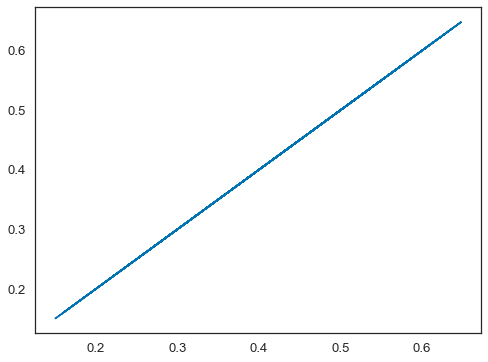

In [78]:
# Not sure why it is not...
plt.plot(y_pred,joint_pred)

In [79]:
# the biases for the 1st three cases
joint_bias[:3]

array([0.42192522, 0.42192522, 0.42192522])

In [80]:
# 96 observation in test set
len(joint_contrib)

96

In [81]:
# A dictionary with each feature combination and its joint contribution?
joint_contrib[0]

{(0, 1): array([0.01798598]),
 (0, 1, 2, 5): array([-0.00030711]),
 (0, 1, 5): array([0.00219443]),
 (1,): array([-0.00560297]),
 (1, 5, 7): array([0.00012034]),
 (1, 3, 5, 7): array([8.11334659e-05]),
 (1, 5): array([-0.00154495]),
 (0, 1, 6, 7): array([0.00044296]),
 (1, 6, 7): array([-0.00066842]),
 (1, 6): array([0.00019965]),
 (6,): array([-0.00031758]),
 (0,): array([0.01033785]),
 (0, 1, 4, 6): array([0.00024679]),
 (0, 1, 4, 5, 6, 7): array([-0.00019111]),
 (0, 1, 4, 6, 7): array([-0.00010215]),
 (0, 1, 6): array([0.00124423]),
 (0, 6): array([1.2766353e-05]),
 (0, 1, 3): array([-0.00129274]),
 (0, 1, 2, 3): array([-0.00054846]),
 (0, 1, 5, 6, 7): array([-9.99545644e-05]),
 (6, 7): array([-3.75418567e-05]),
 (0, 1, 7): array([0.00325545]),
 (0, 1, 4): array([0.00362144]),
 (0, 1, 2, 5, 6): array([-0.00018245]),
 (0, 5, 6): array([8.90807483e-05]),
 (5, 6): array([0.00012895]),
 (0, 1, 5, 6): array([0.00117303]),
 (0, 1, 2, 3, 5, 6): array([-0.00061235]),
 (0, 5): array([0.00043

In [82]:
# tuples representing the column indexes of our features
# Q: How to figure out which index point to which feature?
list(joint_contrib[0].keys())[:3]

[(0, 1), (0, 1, 2, 5), (0, 1, 5)]

In [83]:
# an example of a joint feature contribution
# For the 1st test instance, between features with indices 0 and 1
joint_contrib[0][(0, 1)]

array([0.01798598])

In [153]:
def create_ordered_joint_contrib_df(contrib):
    """
    Creates a dataframe from the joint contribution info, where the
    feature combinations are ordered (in descending fashion) by the absolute
    value of the joint contribution.
    """
    df = pd.DataFrame(contrib, columns=['feat_interaction', 'contribution'])
    # get the reordered index    
    new_idx = (df.contribution.abs()
                              .sort_values(inplace=False, ascending=False)
                              .index)
    df = df.reindex(new_idx).reset_index(drop=True)
    return df

# add the names of the feats to the joint contributions
joint_contrib_w_feat_names = []
# for each observation in the join contributions
for obs in joint_contrib:
    # create a list
    obs_contrib = []
    # for each tuple of column indexes
    for k in obs.keys():
        # get the associated feature names
        feature_combo = [features[i] for i in k]
        # get the contribution value
        contrib = obs[k]
        # store that information in the observation individual list
        obs_contrib.append([feature_combo, contrib])
    # append that individual to the large list containing each observations
    # joint feature contributions
    joint_contrib_w_feat_names.append(obs_contrib)

# create an ordered dataframe for each player
joint_contrib_dfs = [create_ordered_joint_contrib_df(contrib)
                     for contrib in joint_contrib_w_feat_names]
# now combine them all
joint_contrib_df = pd.concat(joint_contrib_dfs, keys=test_df.Player, names=['Player'])

# edit feat_interaction column so the values are strings and not lists
joint_contrib_df['feat_interaction'] = joint_contrib_df.feat_interaction.apply(' | '.join) 

In [85]:
joint_contrib_df.head(16)

feat_interaction  \
Player                                                              
Frank Alexander 0                                      Forty | Wt   
                1                                           Forty   
                2                                              Wt   
                3                          Forty | Wt | BenchReps   
                4                            Forty | Wt | Shuttle   
                5                          Forty | Wt | BroadJump   
                6                                       BenchReps   
                7                                  Wt | BroadJump   
                8                           Forty | Wt | Vertical   
                9                                   Wt | Vertical   
                10                              Forty | Wt | Cone   
                11                  Forty | Wt | BroadJump | Cone   
                12             Forty | Wt | BenchReps | BroadJump   
                13                              Forty | BenchReps   
                14  Forty | Wt | Vertical | BenchReps | BroadJump   
                15      Forty | Wt | BenchReps | BroadJump | Cone   

                                contribution  
Player                                        
Frank Alexander 0       [0.0179859760985322]  
                1      [0.01033784901641225]  
                2    [-0.005602974092915721]  
                3    [0.0036214403791016902]  
                4       [0.0032554505212993]  
                5     [0.002194429322907108]  
                6     [0.001588979379703376]  
                7    [-0.001544945988707492]  
                8   [-0.0012927376339302468]  
                9   [-0.0012886003177287175]  
                10   [0.0012442330319325198]  
                11   [0.0011730263927854244]  
                12    [0.001071221503358525]  
                13   [0.0008991752677696311]  
                14   [0.0008789218373875915]  
                15   [0.0008208742900006133]

In [154]:
# The values are in a list, deal with it
joint_contrib_df_clean = joint_contrib_df.copy()
for index, row in joint_contrib_df_clean.iterrows():
    row['contribution'] = row['contribution'][0]
joint_contrib_df_clean.head(16)

feat_interaction contribution
Player                                                                        
Frank Alexander 0                                      Forty | Wt     0.017986
                1                                           Forty    0.0103378
                2                                              Wt  -0.00560297
                3                          Forty | Wt | BenchReps   0.00362144
                4                            Forty | Wt | Shuttle   0.00325545
                5                          Forty | Wt | BroadJump   0.00219443
                6                                       BenchReps   0.00158898
                7                                  Wt | BroadJump  -0.00154495
                8                           Forty | Wt | Vertical  -0.00129274
                9                                   Wt | Vertical   -0.0012886
                10                              Forty | Wt | Cone   0.00124423
                11                  Forty | Wt | BroadJump | Cone   0.00117303
                12             Forty | Wt | BenchReps | BroadJump   0.00107122
                13                              Forty | BenchReps  0.000899175
                14  Forty | Wt | Vertical | BenchReps | BroadJump  0.000878922
                15      Forty | Wt | BenchReps | BroadJump | Cone  0.000820874

### Individual and joint feature importance for the test set - global

In [155]:
# first get the sum of the absolute values for each joint feature contribution
# This is a pandas.core.series.Series
abs_imp_joint_contrib = (joint_contrib_df_clean.groupby('feat_interaction')
                                          .contribution
                                          .apply(lambda x: x.abs().sum())
                                           .sort_values(ascending=False))
# top 15 feature/combinations
abs_imp_joint_contrib.head(15)

feat_interaction
Forty | Wt                       3.671681
Wt                               3.098026
Forty                            2.783102
Forty | Wt | Cone                0.704606
Forty | Wt | BroadJump           0.554972
Wt | BroadJump                   0.504230
Forty | Wt | Shuttle             0.453822
Forty | Wt | BenchReps           0.390618
Wt | Cone                        0.349964
Cone                             0.307575
Forty | Wt | Vertical            0.252344
Forty | Shuttle                  0.241383
BenchReps                        0.234762
Forty | Cone                     0.223619
Forty | Wt | BroadJump | Cone    0.217157
Name: contribution, dtype: float64

In [156]:
# then calculate the % of total contribution by dividing by the sum of all absolute vals
rel_imp_join_contrib = abs_imp_joint_contrib / abs_imp_joint_contrib.sum()

# Top 15 inverted
rel_imp_join_contrib_inv = rel_imp_join_contrib.head(15)[::-1]
rel_imp_join_contrib_inv

feat_interaction
Forty | Wt | BroadJump | Cone    0.011950
Forty | Cone                     0.012306
BenchReps                        0.012919
Forty | Shuttle                  0.013283
Forty | Wt | Vertical            0.013886
Cone                             0.016926
Wt | Cone                        0.019259
Forty | Wt | BenchReps           0.021496
Forty | Wt | Shuttle             0.024974
Wt | BroadJump                   0.027748
Forty | Wt | BroadJump           0.030540
Forty | Wt | Cone                0.038775
Forty                            0.153154
Wt                               0.170485
Forty | Wt                       0.202053
Name: contribution, dtype: float64

In [158]:
# The plotting command in the next cell through a TypeError, : no numeric data to plot
# Try to modify the series to see if it is because the values are in lists

# DEALT WITH THIS IN STEP 154. NO LONGER NEEDED

# Pandas Series is a one-dimensional labeled array capable of holding data of any type
#for i in rel_imp_join_contrib_inv.axes[0]:
#    val = rel_imp_join_contrib_inv[i][0]
#    rel_imp_join_contrib_inv[i] = val
#rel_imp_join_contrib_inv # a pandas series

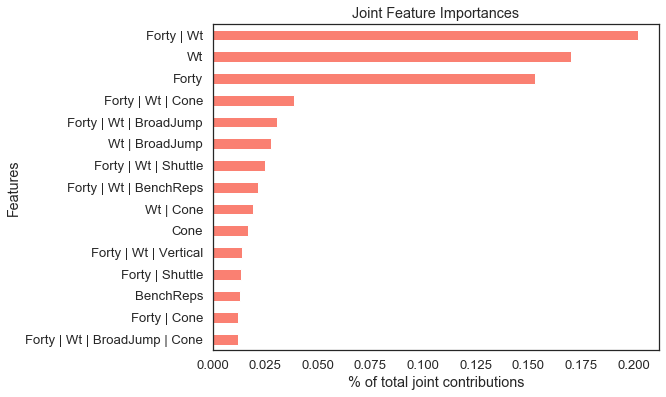

In [159]:
rel_imp_join_contrib_inv.plot(kind='barh', 
                              color='salmon',
                              title='Joint Feature Importances')
plt.ylabel('Features')
plt.xlabel('% of total joint contributions');

### Joint contribution for the test set - global

In [160]:
top_feat_interactions = rel_imp_join_contrib_inv.head(15).index
top_feat_interactions

Index(['Forty | Wt | BroadJump | Cone', 'Forty | Cone', 'BenchReps',
       'Forty | Shuttle', 'Forty | Wt | Vertical', 'Cone', 'Wt | Cone',
       'Forty | Wt | BenchReps', 'Forty | Wt | Shuttle', 'Wt | BroadJump',
       'Forty | Wt | BroadJump', 'Forty | Wt | Cone', 'Forty', 'Wt',
       'Forty | Wt'],
      dtype='object', name='feat_interaction')

In [161]:
top_contrib_mask = joint_contrib_df.feat_interaction.isin(top_feat_interactions)
top_contrib_mask

Player             
Frank Alexander  0      True
                 1      True
                 2      True
                 3      True
                 4      True
                       ...  
Zack Wagenmann   92    False
                 93    False
                 94    False
                 95    False
                 96    False
Name: feat_interaction, Length: 10642, dtype: bool

In [163]:
data_top_contrib_mask = joint_contrib_df_clean.loc[top_contrib_mask]
data_top_contrib_mask  # A data pandas dataframe

feat_interaction contribution
Player                                                 
Frank Alexander 0               Forty | Wt     0.017986
                1                    Forty    0.0103378
                2                       Wt  -0.00560297
                3   Forty | Wt | BenchReps   0.00362144
                4     Forty | Wt | Shuttle   0.00325545
...                                    ...          ...
Zack Wagenmann  12    Forty | Wt | Shuttle   0.00276966
                16            Forty | Cone   0.00218803
                21         Forty | Shuttle   0.00122594
                26               Wt | Cone  0.000828583
                75       Forty | Wt | Cone  0.000105441

[1440 rows x 2 columns]

In [164]:
# The contribution here is in a list, change it to float

# DEALT WITH THIS IN STEP 154. NO LONGER NEEDED

#ef get_1st_element(x):
#   return x[0]

#ata_top_contrib_mask['contribution'] = data_top_contrib_mask['contribution'].apply(get_1st_element)
#ata_top_contrib_mask

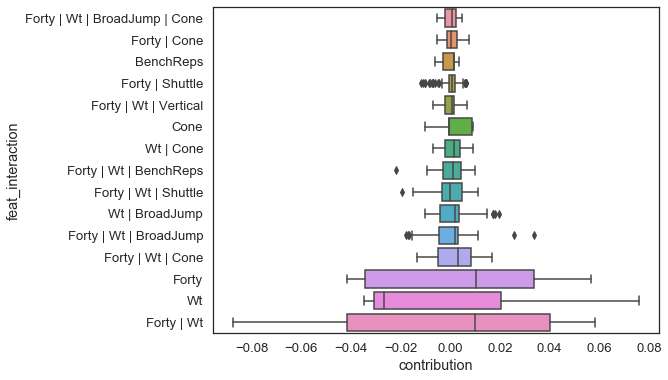

In [165]:
sns.boxplot(y='feat_interaction', x='contribution', 
            data=data_top_contrib_mask,
            orient='h', order=top_feat_interactions);

### Joint contribution for the test set - local

In [166]:
# Get data for a particular player
fa = data_top_contrib_mask.loc['Frank Alexander',:]
fa

,feat_interaction,contribution
0,Forty | Wt,0.017986
1,Forty,0.0103378
2,Wt,-0.00560297
3,Forty | Wt | BenchReps,0.00362144
4,Forty | Wt | Shuttle,0.00325545
5,Forty | Wt | BroadJump,0.00219443
6,BenchReps,0.00158898
7,Wt | BroadJump,-0.00154495
8,Forty | Wt | Vertical,-0.00129274
10,Forty | Wt | Cone,0.00124423


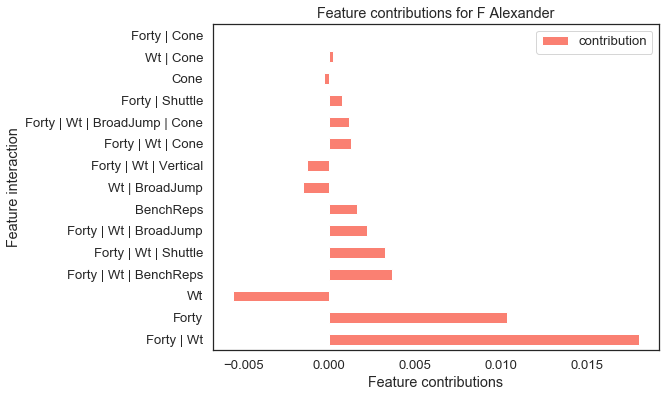

In [167]:
fa.plot(x = 'feat_interaction', kind='barh', 
        color='salmon', title='Feature contributions for F Alexander')
plt.ylabel('Feature interaction')
plt.xlabel('Feature contributions');

### Predictions and joint contribution

In [168]:
# joint_contrib_df: a datafram with two columns: feature interactions and contribution
#                   player as index, and different feature interactions as rows

for index, row in joint_contrib_df.iterrows():
    row['contribution'] = row['contribution'][0]
joint_contrib_df.head(2)

feat_interaction contribution
Player                                         
Frank Alexander 0       Forty | Wt     0.017986
                1            Forty    0.0103378

In [169]:
joint_contrib_heatmap_df = (joint_contrib_df[top_contrib_mask]
                               .groupby(['Player','feat_interaction'])
                               .contribution
                               .aggregate('first')
                               .unstack())
joint_contrib_heatmap_df = joint_contrib_heatmap_df.fillna(0)
joint_contrib_heatmap_df.head(2)

feat_interaction,BenchReps,Cone,Forty,Forty | Cone,Forty | Shuttle,Forty | Wt,Forty | Wt | BenchReps,Forty | Wt | BroadJump,Forty | Wt | BroadJump | Cone,Forty | Wt | Cone,Forty | Wt | Shuttle,Forty | Wt | Vertical,Wt,Wt | BroadJump,Wt | Cone
Player,,,,,,,,,,,,,,,
Frank Alexander,0.001589,-0.000318,0.010338,0.000013,0.000736,0.017986,0.003621,0.002194,0.001173,0.001244,0.003255,-0.001293,-0.005603,-0.001545,0.000200
Jake Bequette,0.001589,0.009301,0.017223,0.004126,0.002378,0.042015,0.005827,0.003153,0.003059,0.009832,0.005909,0.001019,0.020271,0.002999,0.007596


In [170]:
# Add true and predicted AV percentile columns
joint_contrib_heatmap_df = joint_contrib_heatmap_df.merge(y_test_and_pred_df, 
                                                          how='left',
                                                          right_index=True, 
                                                          left_index=True)
joint_contrib_heatmap_df.head(2)

,BenchReps,Cone,Forty,Forty | Cone,Forty | Shuttle,Forty | Wt,Forty | Wt | BenchReps,Forty | Wt | BroadJump,Forty | Wt | BroadJump | Cone,Forty | Wt | Cone,Forty | Wt | Shuttle,Forty | Wt | Vertical,Wt,Wt | BroadJump,Wt | Cone,true_AV_pctile,pred_AV_pctile
Player,,,,,,,,,,,,,,,,,
Frank Alexander,0.001589,-0.000318,0.010338,0.000013,0.000736,0.017986,0.003621,0.002194,0.001173,0.001244,0.003255,-0.001293,-0.005603,-0.001545,0.000200,0.621359,0.457392
Jake Bequette,0.001589,0.009301,0.017223,0.004126,0.002378,0.042015,0.005827,0.003153,0.003059,0.009832,0.005909,0.001019,0.020271,0.002999,0.007596,0.002427,0.592134


In [171]:
# sort by predictions
joint_contrib_heatmap_df.sort_values('pred_AV_pctile', ascending=True, 
                                     inplace=True)
joint_contrib_heatmap_df.head(2)

,BenchReps,Cone,Forty,Forty | Cone,Forty | Shuttle,Forty | Wt,Forty | Wt | BenchReps,Forty | Wt | BroadJump,Forty | Wt | BroadJump | Cone,Forty | Wt | Cone,Forty | Wt | Shuttle,Forty | Wt | Vertical,Wt,Wt | BroadJump,Wt | Cone,true_AV_pctile,pred_AV_pctile
Player,,,,,,,,,,,,,,,,,
Brandon Jenkins,-0.003252,-0.000318,-0.041633,-0.002392,-0.000337,-0.087462,-0.006602,-0.017851,-0.004494,-0.01033,-0.006333,-0.006302,-0.034726,-0.004711,-0.004016,0.002427,0.150607
Tevin Mims,-0.003252,-0.000318,-0.035064,-0.001274,-0.000388,-0.082856,-0.007366,-0.016491,-0.003225,-0.01223,-0.006636,-0.006693,-0.030667,-0.006863,-0.002575,0.002427,0.158456


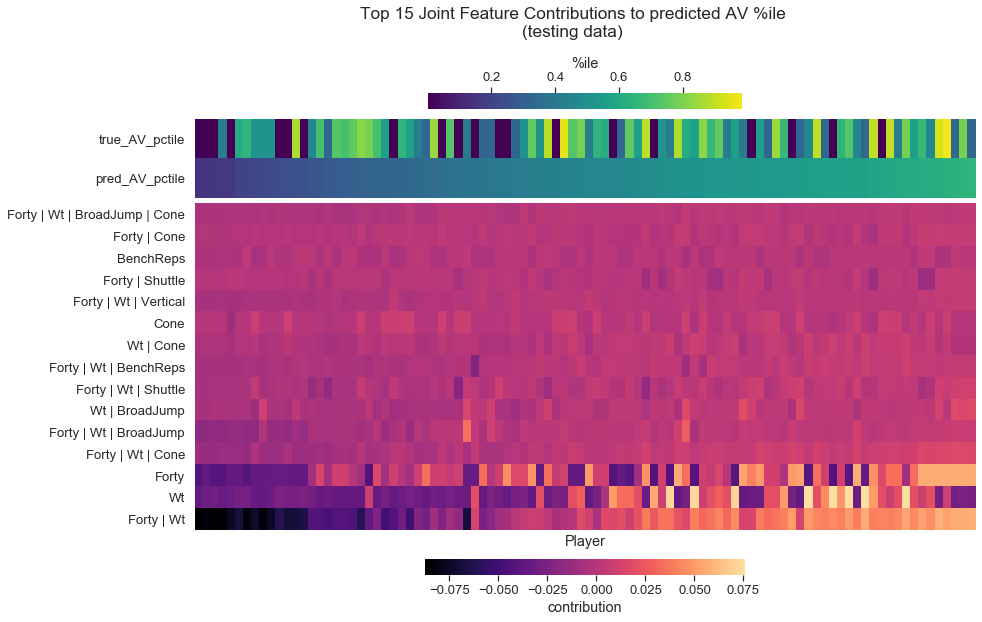

In [173]:
title = 'Top 15 Joint Feature Contributions to predicted AV %ile\n(testing data)'
fig = double_heatmap(joint_contrib_heatmap_df[['true_AV_pctile', 'pred_AV_pctile']].T,
                     joint_contrib_heatmap_df[top_feat_interactions].T, 
                     cbar_label1='%ile', cbar_label2='contribution', 
                     title=title)

## Individual conditional expectation plot

### Purpose and procedure
Visualize how changes for a given feature impact the predictions for one or a a set of observations.
* Pick a feature $f$
* For each individual, make predicting across possible $f$ values, while holding other features constant

In [186]:
from pycebox.ice import ice, ice_plot

# pcyebox likes the data to be in a DataFrame so let's create one with our imputed data
train_X_imp_df = pd.DataFrame(train_X_imp, columns=features)

# Note: train_X_imp is the "imp"uted training data
# row: 316 individual, column: 8 features
train_X_imp_df.shape

(316, 8)

### Exampel feature of interest - Forty

In [182]:
# A data frame with 65 rows and 316 columns
forty_ice_df = ice(data=train_X_imp_df, column='Forty', 
                   predict=search.predict)
forty_ice_df
# Look like the rows are 65 bins for Forty values
# Q: In the colume names, why is there a missing value betwen 4.53 and 4.56?

data_Forty      4.47      4.48      4.53      4.56                4.57  \
Wt             266.0     266.0     266.0     269.0     270.0     267.0   
Ht              76.0      73.0      74.0      76.0      74.0      75.0   
Vertical        34.5      33.0      35.0      31.5      38.5      36.5   
BenchReps       33.0      28.0      28.0      25.0      24.0      31.0   
BroadJump      114.0     114.0     120.0     111.0     120.0     123.0   
Cone           7.365     7.365     7.460     7.380     7.365     7.990   
Shuttle         4.41      4.41      4.43      4.51      4.42      4.48   
Forty                                                                    
4.47        0.606952  0.615978  0.603252  0.500572  0.649966  0.485131   
4.48        0.606952  0.615978  0.603252  0.500572  0.649966  0.485131   
4.53        0.603408  0.611526  0.600218  0.497359  0.646932  0.483991   
4.56        0.603408  0.610071  0.600218  0.495505  0.646932  0.483991   
4.57        0.603408  0.610071  0.600218  0.495505  0.646932  0.483991   
...              ...       ...       ...       ...       ...       ...   
5.14        0.199561  0.195913  0.201227  0.187121  0.285160  0.231061   
5.15        0.199561  0.195913  0.201227  0.187121  0.285160  0.231061   
5.16        0.199561  0.195913  0.201227  0.187121  0.285160  0.231061   
5.20        0.199561  0.195913  0.201227  0.187121  0.285160  0.231061   
5.24        0.199561  0.195913  0.201227  0.187121  0.285160  0.231061   

data_Forty      4.58      4.59      4.60      4.61  ...      5.09      5.10  \
Wt             262.0     259.0     275.0     248.0  ...     287.0     254.0   
Ht              75.0      75.0      75.0      76.0  ...      79.0      75.0   
Vertical        34.0      35.5      33.0      38.5  ...      29.0      34.0   
BenchReps       16.0      26.0      24.0      24.0  ...      26.0      21.0   
BroadJump      120.0     110.0     114.0     129.0  ...     108.0     119.0   
Cone           7.110     7.270     7.365     6.970  ...     7.490     7.365   
Shuttle         4.07      4.38      4.41      4.48  ...      4.64      4.41   
Forty                                               ...                       
4.47        0.591633  0.579461  0.640132  0.566379  ...  0.614262  0.544795   
4.48        0.591633  0.579461  0.640132  0.566379  ...  0.614262  0.544795   
4.53        0.590726  0.575803  0.637368  0.566379  ...  0.614262  0.542089   
4.56        0.590726  0.575803  0.637368  0.566379  ...  0.614262  0.542089   
4.57        0.590726  0.575803  0.637368  0.566379  ...  0.614262  0.542089   
...              ...       ...       ...       ...  ...       ...       ...   
5.14        0.217185  0.175555  0.364295  0.350346  ...  0.535621  0.164099   
5.15        0.217185  0.175555  0.364295  0.350346  ...  0.535621  0.164099   
5.16        0.217185  0.175555  0.364295  0.350346  ...  0.535621  0.164099   
5.20        0.217185  0.175555  0.364295  0.350346  ...  0.535621  0.164099   
5.24        0.217185  0.175555  0.364295  0.350346  ...  0.535621  0.164099   

data_Forty                5.12      5.13      5.14      5.15      5.16  \
Wt             283.0     305.0     283.0     262.0     249.0     280.0   
Ht              75.0      79.0      76.0      74.0      74.0      75.0   
Vertical        33.0      29.0      30.0      28.5      25.5      36.0   
BenchReps       24.0      23.0      18.0      22.0      20.0      26.0   
BroadJump      114.0     106.0     101.0     106.0     107.0     114.0   
Cone           7.365     7.365     7.910     7.190     7.610     7.580   
Shuttle         4.41      4.41      4.68      4.46      4.73      4.43   
Forty                                                                    
4.47        0.655528  0.647327  0.461080  0.501274  0.374910  0.608658   
4.48        0.655528  0.647327  0.461080  0.501274  0.374910  0.608658   
4.53        0.653750  0.647327  0.461080  0.499201  0.373769  0.606881   
4.56        0.653750  0.647327  0.461080  0.497745

### Draw ICE plot

Text(0.5, 0, 'Forty')

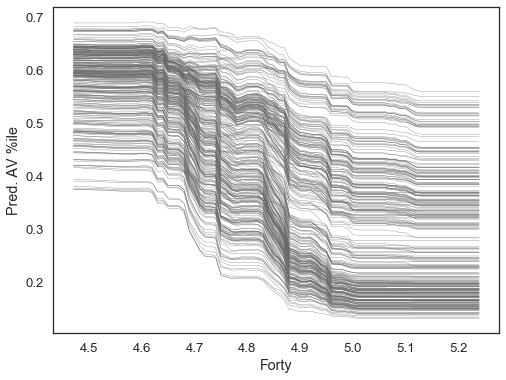

In [187]:
ice_plot(forty_ice_df, c='dimgray', linewidth=0.3)
plt.ylabel('Pred. AV %ile')
plt.xlabel('Forty')

Observations:
* AV tend to decrease as Forty increase
* But players with high AVs does not decrease as much as Forty increase
  * **Inference: Forty is interacting with something else, otherwlse everybody will decrease in the same way**

### Inspect feature interaction in ICE plot

Example: interaction between Forty and Wt

In [189]:
# Detour: check color map
# https://matplotlib.org/gallery/color/colormap_reference.html
import matplotlib.cm
print(matplotlib.cm.cmap_d.keys())

dict_keys(['Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'Blues_r', 'BrBG_r', 'BuGn_r', 'BuPu_r', 'CMRmap_r', 'GnBu_r', 'Greens_r', 'Greys_r', 'OrRd_r', 'Oranges_r', 'PRGn_r', 'PiYG_r', 'PuBu_r', 'PuBuGn_r', 'PuOr_r', 'PuRd_r', 'Purples_r', 'RdBu_r', 'RdGy_r', 'RdPu_r', 'RdYlBu_r', 'RdYlGn_r', 'Reds_r', 'Spectral

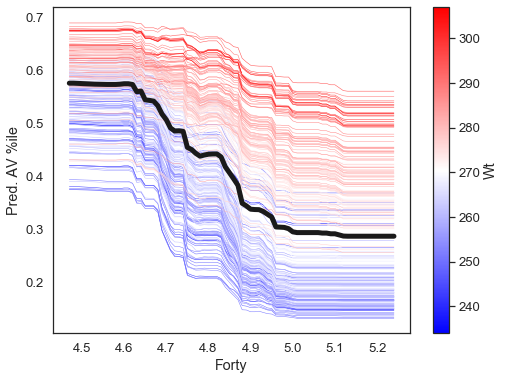

In [191]:
# new colormap for ICE plot
cmap2 = plt.get_cmap('bwr')

# set color_by to Wt, in order to color each curve by that player's weight
# We can also add the PDP by setting the plot_pdp to True in the ice_plot function. 
# To adjust the styling of the PDP line we pass a dictionary of settings to pdp_kwargs.
ice_plot(forty_ice_df, linewidth=0.5, color_by='Wt', cmap=cmap2,
         plot_pdp=True, 
         pdp_kwargs={'c': 'k', 'linewidth': 5})

# ice_plot doesn't return a colorbar so we have to add one
# hack to add in colorbar taken from here:
# https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots/11558629#11558629
wt_vals = forty_ice_df.columns.get_level_values('Wt').values
sm = plt.cm.ScalarMappable(cmap=cmap2, 
                           norm=plt.Normalize(vmin=wt_vals.min(), 
                                              vmax=wt_vals.max()))
# need to create fake array for the scalar mappable or else we get an error
sm._A = []
plt.colorbar(sm, label='Wt')
plt.ylabel('Pred. AV %ile')
plt.xlabel('Forty');

### Partial dependence plot (PDP)

Define:
* Shows the marginal effect one or two features have on the predicted outcome of a machine learning model
* **This turns out to the be average of all ICE curves.**

### Centered ICE plots
Relative change of the predictions with respect to the predictions at the centered value
* E.g. centered around minimal Forty value

In [194]:
#
# DOES NOT WORK
#

ice_plot(forty_ice_df, linewidth=0.5, color_by='Wt', cmap=cmap2,
         plot_pdp=True, 
         pdp_kwargs={'c': 'k', 'linewidth': 5},
         centered=True)

plt.colorbar(sm, label='Wt')
plt.ylabel('Pred. AV %ile (centered)')
plt.xlabel('Forty');

NameError: name '__get_quantiles' is not defined

### ICE plots for all features

In [195]:
def plot_ice_grid(dict_of_ice_dfs, data_df, features, ax_ylabel='', nrows=3, 
                  ncols=3, figsize=(12, 12), sharex=False, sharey=True, 
                  subplots_kws={}, rug_kws={'color':'k'}, **ice_plot_kws):
    """A function that plots ICE plots for different features in a grid."""
    fig, axes = plt.subplots(nrows=nrows, 
                             ncols=ncols, 
                             figsize=figsize,
                             sharex=sharex,
                             sharey=sharey,
                             **subplots_kws)
    # for each feature plot the ice curves and add a rug at the bottom of the 
    # subplot
    for f, ax in zip(features, axes.flatten()):
        ice_plot(dict_of_ice_dfs[f], ax=ax, **ice_plot_kws)
        # add the rug
        sns.distplot(data_df[f], ax=ax, hist=False, kde=False, 
                     rug=True, rug_kws=rug_kws)
        ax.set_title('feature = ' + f)
        ax.set_ylabel(ax_ylabel)
        sns.despine()
        
    # get rid of blank plots
    for i in range(len(features), nrows*ncols):
        axes.flatten()[i].axis('off')

    return fig

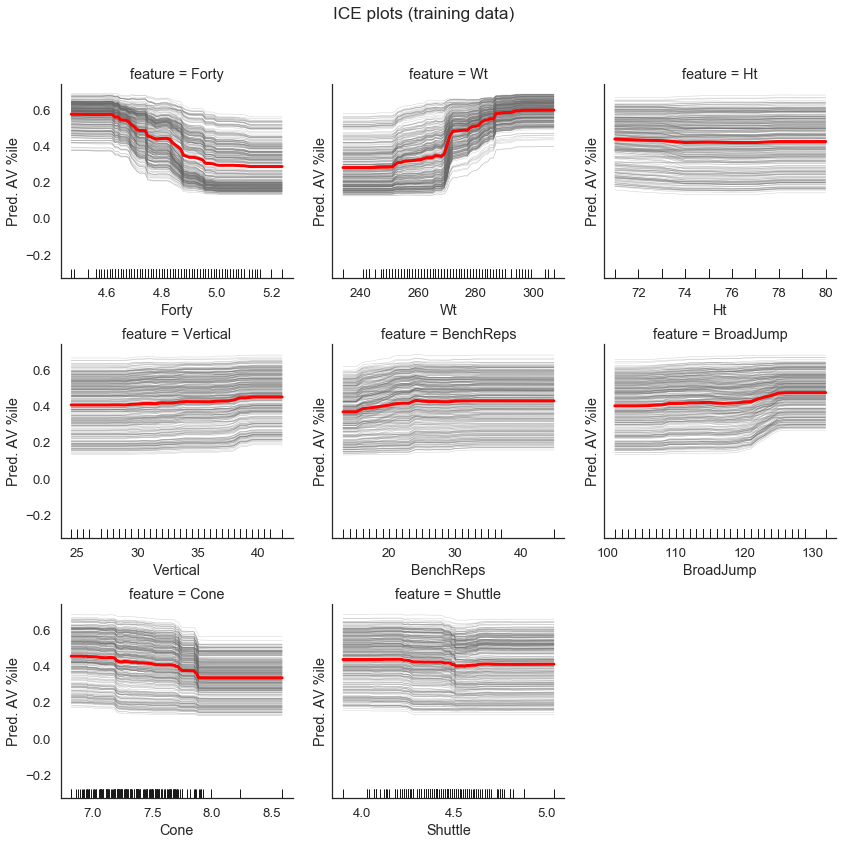

In [196]:
# create dict of ICE data for grid of ICE plots
train_ice_dfs = {feat: ice(data=train_X_imp_df, column=feat, predict=estimator.predict) 
                 for feat in features}

fig = plot_ice_grid(train_ice_dfs, train_X_imp_df, features,
                    ax_ylabel='Pred. AV %ile', alpha=0.3, plot_pdp=True,
                    pdp_kwargs={'c': 'red', 'linewidth': 3},
                    linewidth=0.5, c='dimgray')
fig.tight_layout()
fig.suptitle('ICE plots (training data)')
fig.subplots_adjust(top=0.89);

NameError: name '__get_quantiles' is not defined

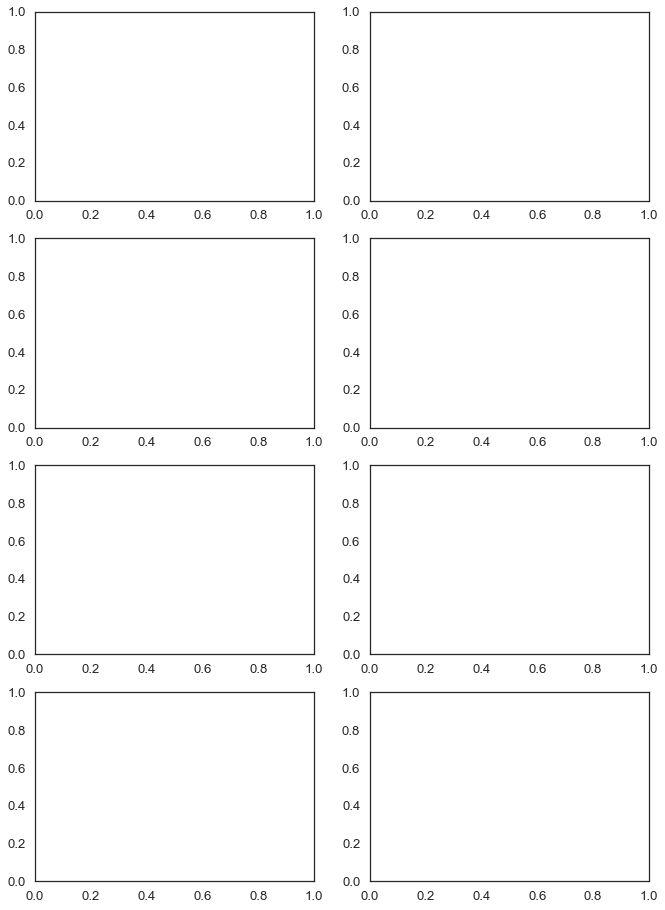

In [197]:
#
# DOES NOT WORK
#

fig = plot_ice_grid(train_ice_dfs, train_X_imp_df, features, 
                    ax_ylabel='Pred AV %ile (centered)',
                    alpha=.2, plot_points=False, plot_pdp=True,
                    pdp_kwargs={"c": "red", "linewidth": 3},
                    linewidth=0.5, c='dimgray', centered=True,
                    sharey=False, nrows=4, ncols=2, figsize=(11,16))
fig.tight_layout()
fig.suptitle('Centered ICE plots (training data)')
fig.subplots_adjust(top=0.9)

### 2-D PDPs
Look at PDPs of two features at once

In [232]:
import itertools
from pdpbox import pdp
from matplotlib.text import Text


#
# THIS FUNCTION DOES NOT WORK
#

def plot_2d_pdp_grid(pdp_inters, feature_pairs,
                     ncols=3, nrows=4, figsize=(13, 16),
                     xaxis_font_size=12, yaxis_font_size=12,
                     contour_line_fontsize=12,
                     tick_labelsize=10, x_quantile=None, 
                     plot_params=None, subplots_kws={}):
    """Plots a grid of 2D PDP plots."""
    # create our subplots to plot our PDPs on
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                             figsize=figsize, **subplots_kws)

    # for each feature pair, plot the 2-D pdp
    for pdp_inter, feat_pair, ax in zip(pdp_inters, feature_pairs, axes.flatten()):
    
        # use pdpbox's _pdp_contour_plot function to actually plot the 2D pdp
        # NOTE: this function is no longer there, use pdp_interact_plot instead
        #pdp._pdp_contour_plot(pdp_inter, feat_pair, 
        #                      x_quantile=x_quantile, ax=ax, 
        #                      plot_params=plot_params,
        #                      fig=None)
        pdp.pdp_interact_plot(pdp_inter, feat_pair,
                              x_quantile=x_quantile, 
                              plot_params=plot_params)
        
        # adjust some font sizes
        ax.tick_params(labelsize=tick_labelsize)
        ax.xaxis.get_label().set_fontsize(xaxis_font_size)
        ax.yaxis.get_label().set_fontsize(yaxis_font_size)
    
        # set the contour line fontsize
        for child in ax.get_children():
            if isinstance(child, Text):
                child.set(fontsize=contour_line_fontsize)   
    
    # get rid of empty subplots
    for i in range(len(pdp_inters), nrows*ncols):
        axes.flatten()[i].axis('off')
        
    return fig

In [205]:
# get each possible feature pair combination
feature_pairs = [list(feat_pair) for feat_pair in itertools.combinations(features, 2)]

# we will only plot the feature iteractions that invlove either Forty or Wt
# just to avoid making soooo many plots
forty_wt_feat_pairs = [fp for fp in feature_pairs if 'Forty' in fp or 'Wt' in fp]

In [220]:
# now calculate the data for the pdp interactions
# we can do that with pdpbox's pdp_interact function
# in the current development version on github, parallelization is supported
# but it didn't work for me so I resorted to using that multiprocess helper
# function from before

# train_feat_inters is a list of pdpbox objects
train_feat_inters = multiproc_iter_func(N_JOBS, forty_wt_feat_pairs, 
                                        pdp.pdp_interact, 'features',
                                        model=estimator, 
                                        dataset=train_X_imp_df,
                                        model_features = features)
# Different from the online doc: 
#  train_X is changed to dataset
#  Add model_features = features

['Forty', 'Wt']
['Forty', 'Ht']
['Forty', 'Vertical']
['Forty', 'BenchReps']
['Forty', 'BroadJump']
['Forty', 'Cone']
['Forty', 'Shuttle']
['Wt', 'Ht']
['Wt', 'Vertical']
['Wt', 'BenchReps']
['Wt', 'BroadJump']
['Wt', 'Cone']
['Wt', 'Shuttle']


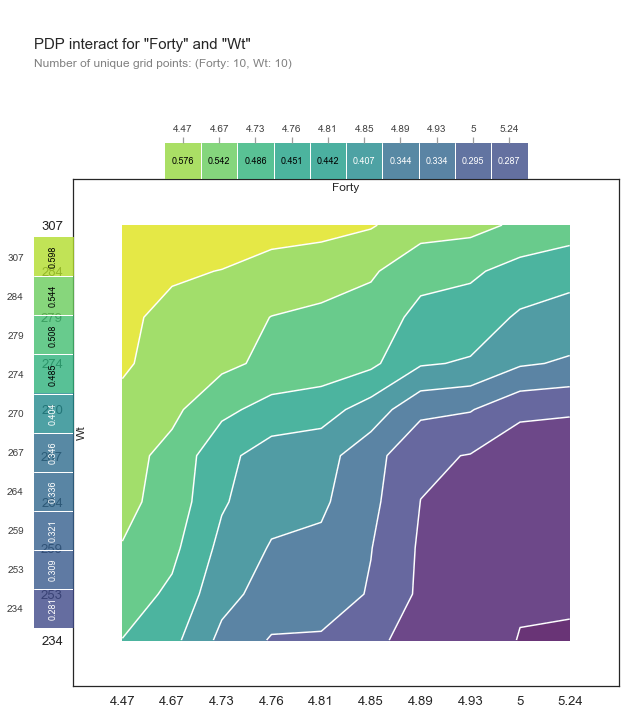

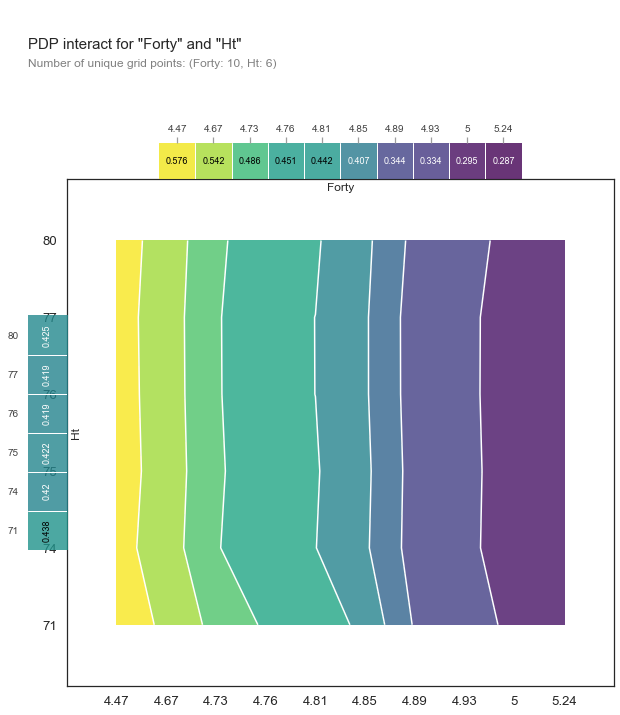

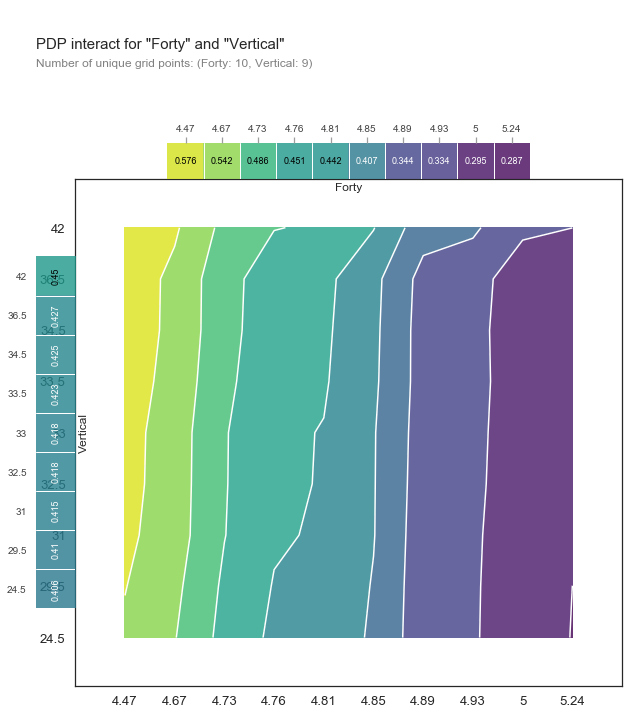

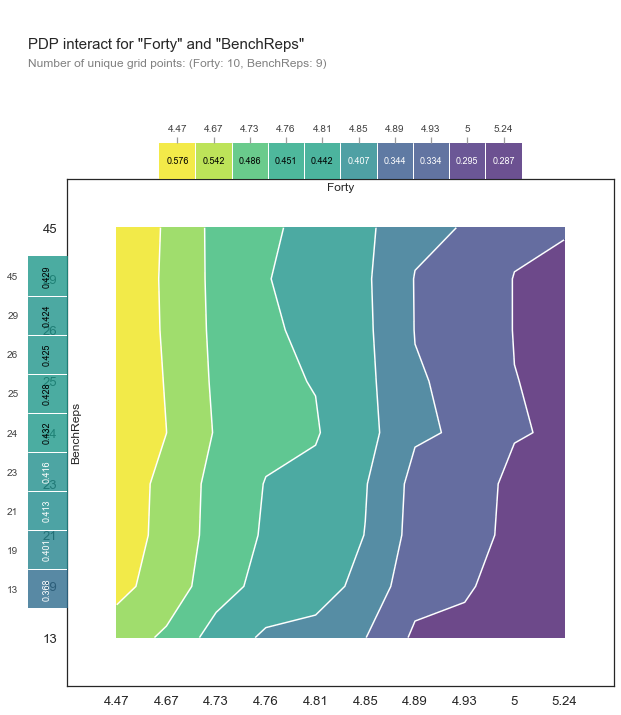

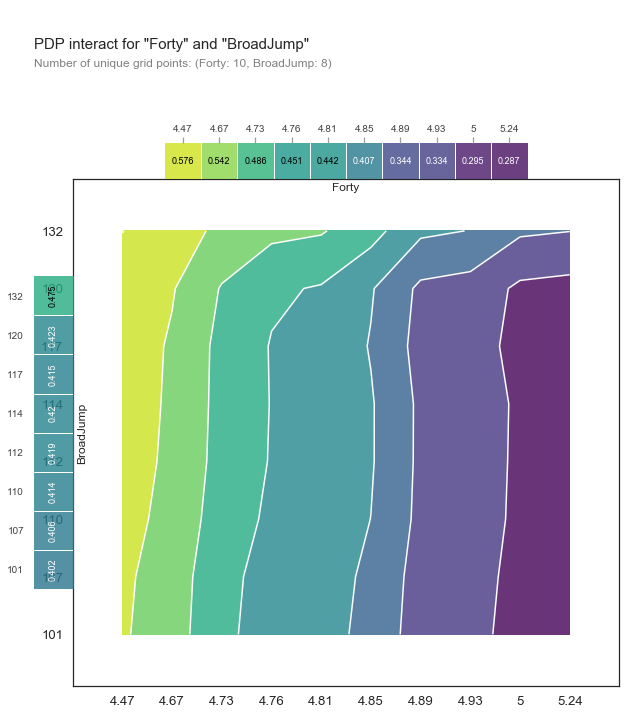

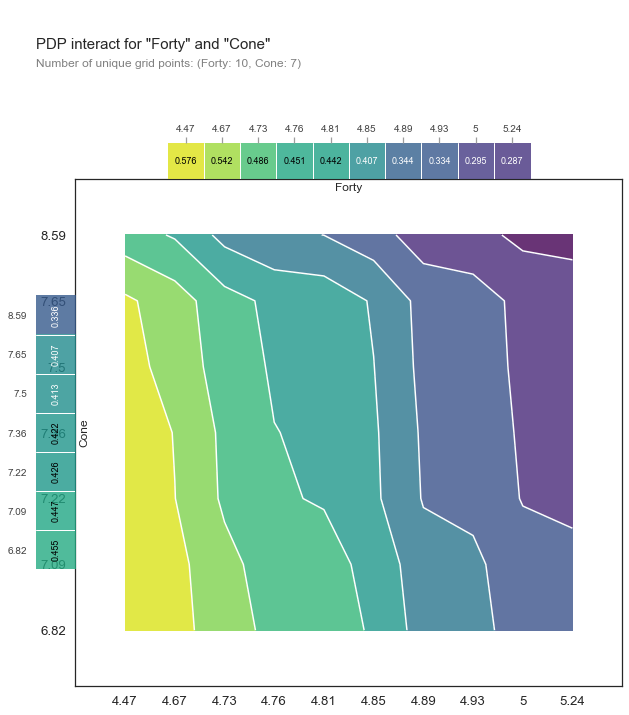

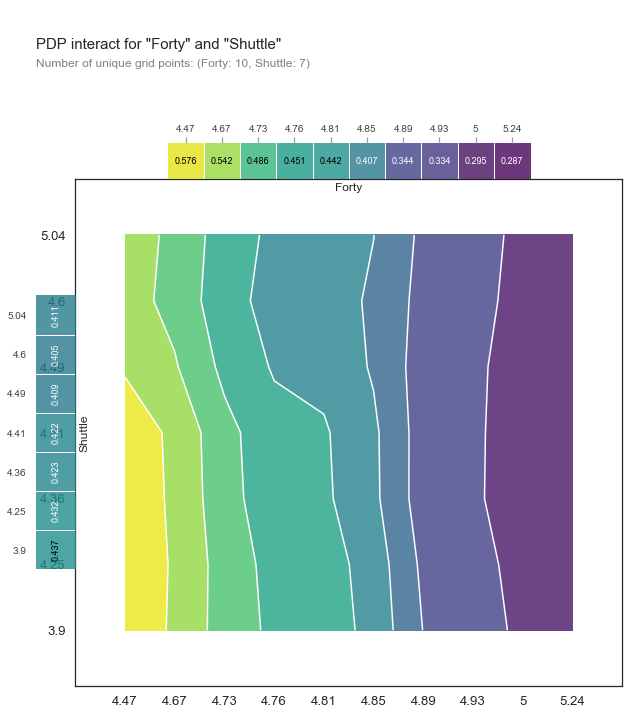

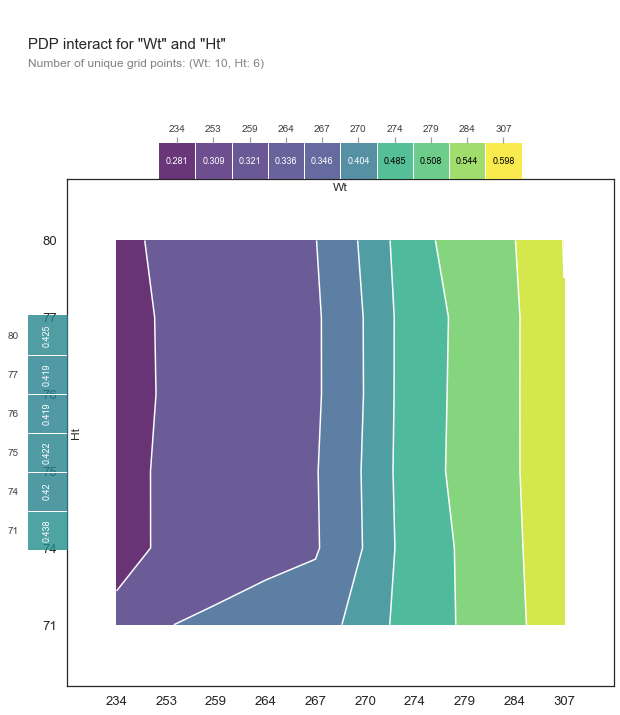

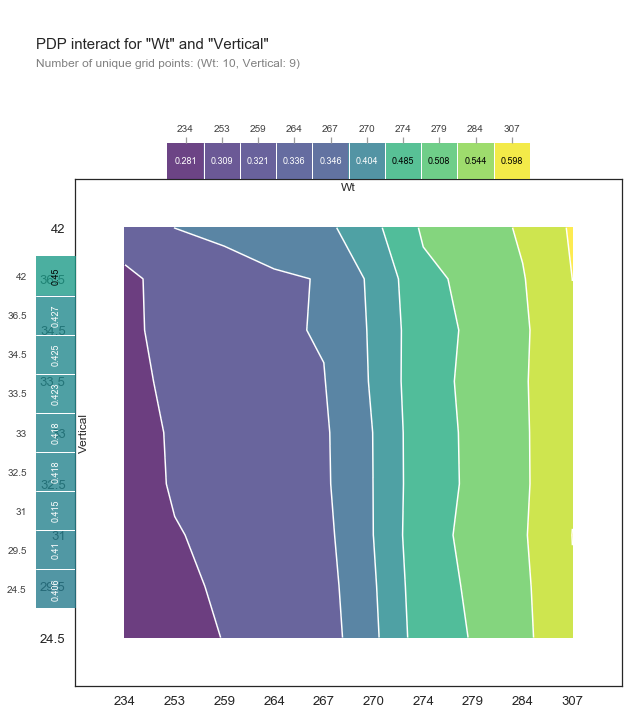

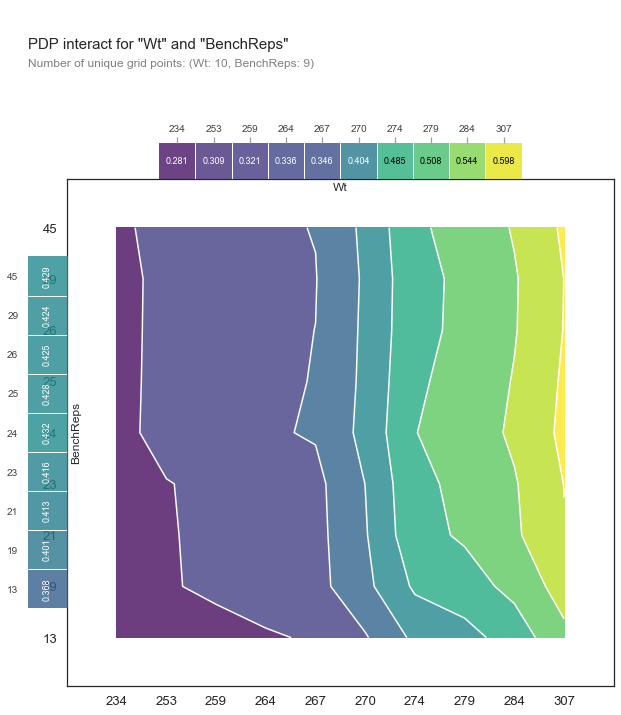

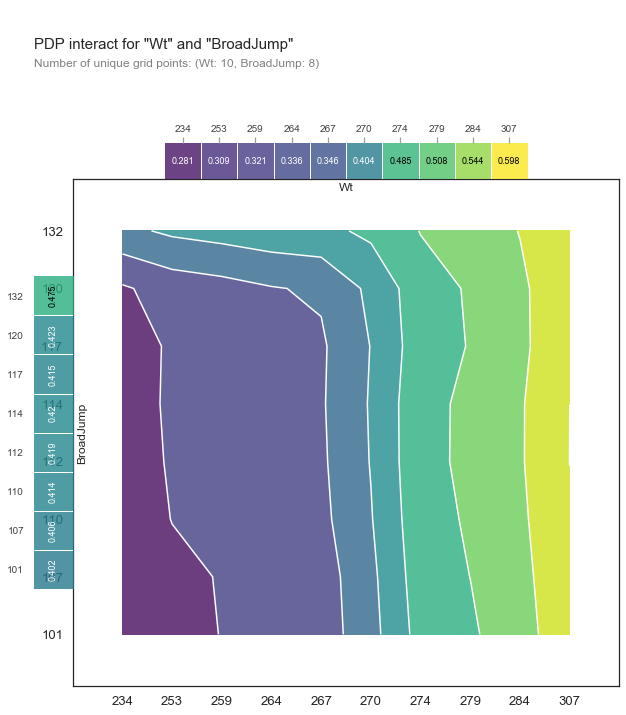

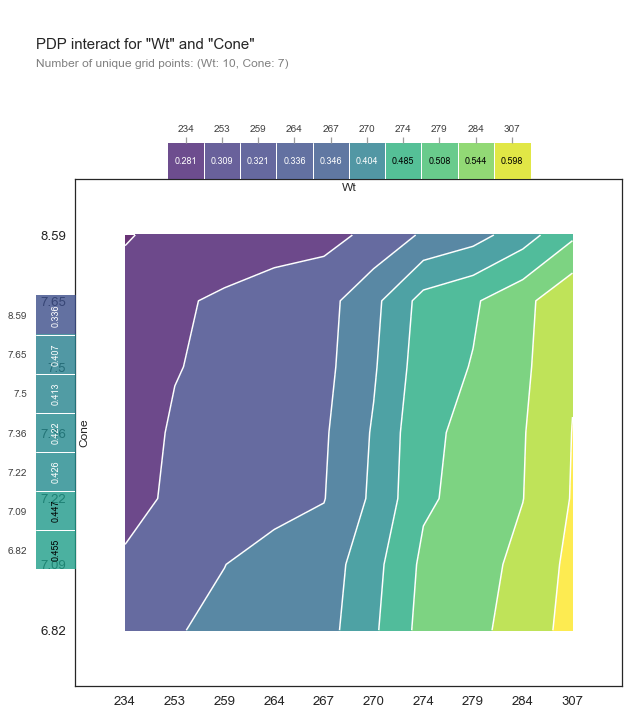

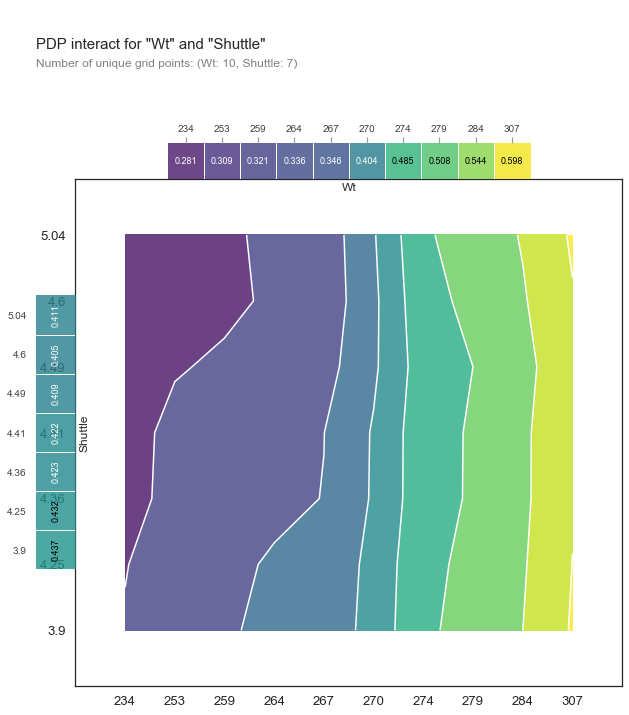

In [240]:
# and now plot a grid of PDP interaction plots
# NOTE that the contour colors do not represent the same values
# across the different subplots
#fig = plot_2d_pdp_grid(train_feat_inters, forty_wt_feat_pairs)
#fig.tight_layout()
#fig.suptitle('PDP Interaction Plots (training data)', fontsize=20)
#fig.subplots_adjust(top=0.95);

pdp_inters    = train_feat_inters
feature_pairs = forty_wt_feat_pairs
for pdp_inter, feat_pair in zip(pdp_inters, feature_pairs):
    # Would throw typeError, know bug not fixed
    # https://github.com/SauceCat/PDPbox/issues/40
    try:
        pdp.pdp_interact_plot(pdp_inter,
                              feat_pair,
                              x_quantile=True,
                              plot_pdp=True)
    except TypeError:
        continue

## Local Interpretable Model-agnostic Explanations

### Packages
* eli5
* Skater
* lime

In [242]:
import lime
from lime.lime_tabular import LimeTabularExplainer

### Explain one instance

In [246]:
# create the explainer by passing our training data, 
# setting the correct modeling mode, pass in feature names and
# make sure we don't discretize the continuous features
explainer = LimeTabularExplainer(train_X_imp_df, mode='regression', 
                                 feature_names=features, 
                                 random_state=RANDOM_STATE, 
                                 discretize_continuous=False) 
# a lime.lime_tabular.LimeTabularExplainer object
dir(explainer)

['_LimeTabularExplainer__data_inverse',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'base',
 'categorical_features',
 'categorical_names',
 'class_names',
 'convert_and_round',
 'discretizer',
 'explain_instance',
 'feature_frequencies',
 'feature_names',
 'feature_selection',
 'feature_values',
 'mode',
 'random_state',
 'sample_around_instance',
 'scaler',
 'training_data_stats',
 'validate_training_data_stats']

In [247]:
test_X_imp_df = pd.DataFrame(test_X_imp, columns=features)
test_X_imp_df.head(2)

,Forty,Wt,Ht,Vertical,BenchReps,BroadJump,Cone,Shuttle
0,4.80,270.0,76.0,33.0,24.0,114.0,7.365,4.41
1,4.75,274.0,77.0,34.0,24.0,113.0,6.900,4.07


In [248]:
# the number of features to include in our predictions
num_features = len(features)
num_features

8

In [250]:
# the index of the instance we want to explaine
exp_idx = 2
exp = explainer.explain_instance(test_X_imp_df.iloc[exp_idx,:].values, 
                                 estimator.predict, num_features=num_features)
# A lime.explanation.Explanation object
dir(exp)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'as_html',
 'as_list',
 'as_map',
 'as_pyplot_figure',
 'available_labels',
 'class_names',
 'domain_mapper',
 'dummy_label',
 'intercept',
 'local_exp',
 'local_pred',
 'max_value',
 'min_value',
 'mode',
 'predicted_value',
 'random_state',
 'save_to_file',
 'scaled_data',
 'score',
 'show_in_notebook']

In [255]:
print(exp.local_pred[0])  # the prediction made by the local surrogate model
print(exp.class_names)
print(exp.dummy_label) 
print(exp.intercept[0])   # the bias term for the local explanation
#print(exp.domain_mapper) #lime.lime_tabular.TableDomainMapper object

0.405533194200986
['negative', 'positive']
1
{0: 0.4021963001353002, 1: 0.4021963001353002}


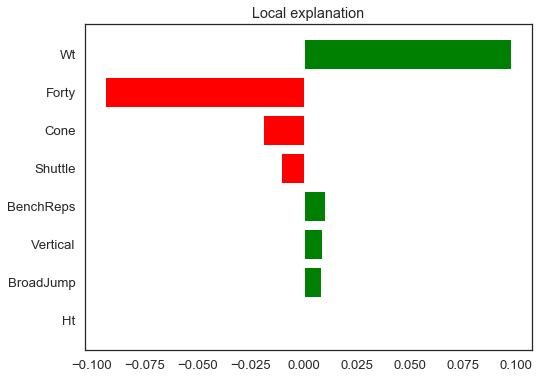

In [257]:
exp.as_pyplot_figure();

### Explain all instances in the test set

In [258]:
lime_expl = test_X_imp_df.apply(explainer.explain_instance, 
                                predict_fn=estimator.predict, 
                                num_features=num_features,
                                axis=1)

In [259]:
from sklearn.metrics import mean_squared_error, r2_score

In [260]:
# get all the lime predictions
lime_pred = lime_expl.apply(lambda x: x.local_pred[0])
# RMSE of lime pred
mean_squared_error(y_pred, lime_pred)**0.5

0.056193560639450885

In [261]:
# r^2 of lime predictions
r2_score(y_pred, lime_pred)

0.8305704275309795

### Optimize local surrogate
Play with the kernel_width parameter
* Default 

In [262]:
# new explainer with smaller kernel_width
better_explainer = LimeTabularExplainer(train_X_imp_df, mode='regression', 
                                        feature_names=features, 
                                        random_state=RANDOM_STATE, 
                                        discretize_continuous=False,
                                        kernel_width=1)  # <-- this value

In [265]:
better_lime_expl = test_X_imp_df.apply(better_explainer.explain_instance, 
                                       predict_fn=estimator.predict, 
                                       num_features=num_features,
                                       axis=1)

In [266]:
# get all the lime predictions
better_lime_pred = better_lime_expl.apply(lambda x: x.local_pred[0])
# RMSE of lime pred
mean_squared_error(y_pred, better_lime_pred)**0.5

0.038171276479699215

In [267]:
# r^2 of lime predictions
r2_score(y_pred, better_lime_pred)

0.9218211138348578

### Heatmap for viewing all explanations

In [268]:
# construct a DataFrame with all the feature weights and bias terms from LIME
# create an individual dataframe for each explanation
lime_dfs = [pd.DataFrame(dict(expl.as_list() + [('bias', expl.intercept[0])]), index=[0]) 
            for expl in better_lime_expl]
# then concatenate them into one big DataFrame
lime_expl_df = pd.concat(lime_dfs, ignore_index=True)

lime_expl_df.head()

,Wt,Forty,Cone,Shuttle,BenchReps,Vertical,BroadJump,Ht,bias
0,0.118130,-0.103421,-0.021213,-0.011683,0.011377,0.008007,0.005772,-0.001568,0.398447
1,0.097985,-0.094254,-0.015153,-0.014535,0.013251,0.009942,0.007355,-0.002545,0.404012
2,0.104206,-0.112821,-0.020847,-0.013006,0.008492,0.007146,0.006490,-0.002808,0.392757
3,0.076864,-0.117118,-0.021018,-0.015832,0.012262,0.013145,0.019577,-0.001308,0.378612
4,0.100153,-0.053554,-0.022861,0.002268,0.006862,0.007131,0.005484,0.007583,0.413141


In [270]:
# scale the data
scaled_X = (test_X_imp_df - explainer.scaler.mean_) / explainer.scaler.scale_
# calc the lime feature contributions
lime_feat_contrib = lime_expl_df[features] * scaled_X

# add on bias term, actual av %ile and predicted %ile
other_lime_cols = ['bias', 'true_AV_pctile', 'pred_AV_pctile']
lime_feat_contrib[other_lime_cols] = pd.DataFrame(np.column_stack((lime_expl_df.bias,
                                                                   y_test_and_pred_df)))

lime_feat_contrib.sort_values('pred_AV_pctile', inplace=True)

lime_feat_contrib.head()

,Forty,Wt,Ht,Vertical,BenchReps,BroadJump,Cone,Shuttle,bias,true_AV_pctile,pred_AV_pctile
33,-0.113054,-0.083653,0.000434,-0.000100,-0.012229,0.000223,0.000263,0.000298,0.337054,0.002427,0.150607
62,-0.077159,-0.074994,-0.000063,-0.015220,-0.026971,-0.004416,0.000209,0.000552,0.385588,0.002427,0.158456
12,-0.086496,-0.038343,-0.002006,-0.008532,-0.009917,0.000295,0.000312,0.003833,0.392701,0.002427,0.160429
78,-0.094501,-0.102338,-0.000628,-0.000081,-0.003525,0.000272,0.000303,0.000640,0.380756,0.415049,0.161420
66,-0.026504,-0.050342,0.004538,-0.016142,-0.032931,0.000266,-0.019472,-0.014708,0.360642,0.002427,0.164711


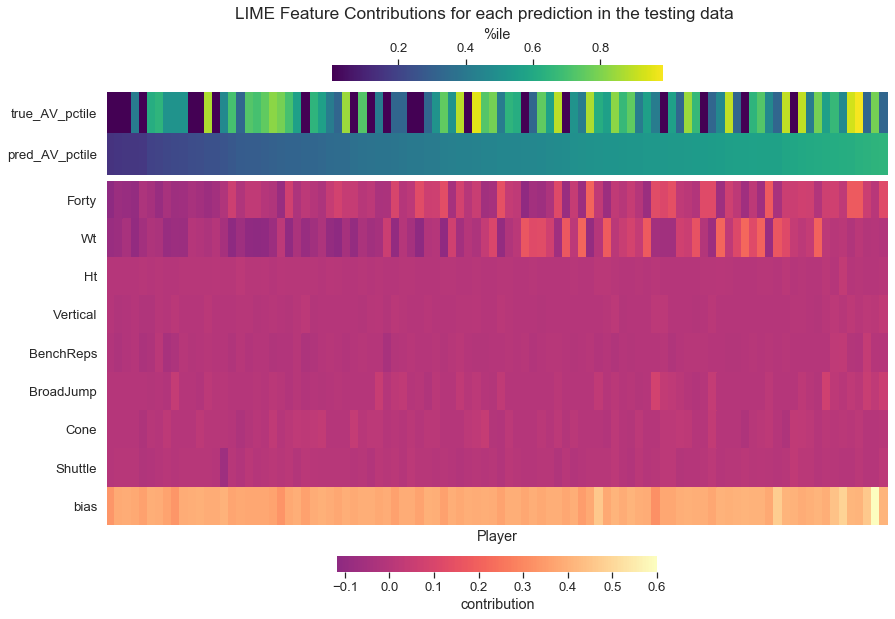

In [271]:
title = 'LIME Feature Contributions for each prediction in the testing data'
fig = double_heatmap(lime_feat_contrib[['true_AV_pctile', 'pred_AV_pctile']].T,
                     lime_feat_contrib.loc[:, :'bias'].T, title=title,
                     cbar_label1='%ile', cbar_label2='contribution', 
                     subplot_top=0.9)
# set the x-axis label for the bottom heatmap
# fig has 4 axes object, the first 2 are the heatmaps, the other 2 are the colorbars
fig.axes[1].set_xlabel('Player');

## SHAP - Shapley addtive explanations

### General idea
Leverages game theory
* Measure the impact of the features on the predictions
* Decision path approach earlier - indiv contributions favor features found toward the terminals of the tree
* SHAP does not rely on feature order in the tree

### Explain one prediction

In [278]:
import shap
dir(shap)

['BruteForceExplainer',
 'DeepExplainer',
 'GradientExplainer',
 'KernelExplainer',
 'LinearExplainer',
 'PartitionExplainer',
 'PermutationExplainer',
 'SamplingExplainer',
 'Tree',
 'TreeExplainer',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_cext',
 'approximate_interactions',
 'bar_plot',
 'common',
 'datasets',
 'decision_plot',
 'dependence_plot',
 'embedding_plot',
 'explainers',
 'force_plot',
 'have_matplotlib',
 'hclust_ordering',
 'image_plot',
 'initjs',
 'kmeans',
 'matplotlib',
 'monitoring_plot',
 'multioutput_decision_plot',
 'other',
 'partial_dependence_plot',
 'plots',
 'sample',
 'save_html',
 'summary_plot',
 'unsupported',
 'warnings',
 'waterfall_plot']

In [280]:
# create our SHAP explainer
shap_explainer = shap.TreeExplainer(estimator)
# calculate the shapley values for our test set
test_shap_vals = shap_explainer.shap_values(test_X_imp)
dir(test_shap_vals)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rlshift__',
 '__rmatmul__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rrshift__',
 '__rshift__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__xor__',
 'all',
 'any',
 'argmax',
 'argmin',
 'argpartition',
 'argsort',
 'astype',
 'base',
 'byteswap',
 'choose',
 'clip',
 'compress',
 'conj',
 'conjugate',
 'copy',
 'ctypes',
 'cumprod',
 'cumsum',
 'data',
 'diagonal',
 'dot',
 'dtype',
 'dump',
 'dumps',
 'fill',
 'flags',
 'flat',
 'flatten',
 'getfield',
 'imag',
 'item',
 'itemset',
 'itemsize',
 'max',
 'mean',
 'min',
 'nbytes',
 'ndim',
 'newbyteorder',
 'nonzero',
 'partition',
 'prod',
 'ptp',
 'put',
 'ravel',
 'real',
 'repeat',
 'reshape',
 'resize',
 'round',
 'searchsorted',
 'setfield',
 'setflags',
 'shape',
 'size',
 'sort',
 'squeeze',
 'std',
 'strides',
 'sum',
 'swapaxes',
 'take',
 'tobytes',
 'tofile',
 'tolist',
 'tostring',
 'trace',
 'transpose',
 'var',
 'view']

In [281]:
# load JS in order to use some of the plotting functions from the shap
# package in the notebook
shap.initjs()

In [291]:
# For the first instance - an array of 8 values, one for each feature
test_shap_vals[0,:]

array([ 0.03080172, -0.00132126, -0.00314924, -0.00401145,  0.01271503,
       -0.00080135,  0.00045999,  0.00077374])

In [296]:
# plot the explanation for a single prediction
# NOTE: Curr shap ver need - predicted value first, then shap value, then the feature val
shap.force_plot(shap_explainer.expected_value, 
                test_shap_vals[0, :], 
                test_X_imp_df.iloc[0, :])

Explanation:
* Base value = a bias term: 0.4219 (**Q: What is this?? Model average?**)
* For this individual, the the value start at somewhere near 0.4119
* Then each feature successively sum to the final value 0.46.
* Some features are positive (red), some negative (blue).

### Explain multiple instances

In [298]:
shap.force_plot(shap_explainer.expected_value, 
                test_shap_vals,
                test_X_imp_df)

### Summarize feature distribution

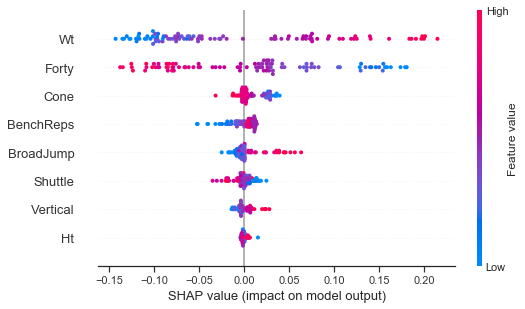

In [300]:
shap.summary_plot(test_shap_vals, 
                  test_X_imp_df, 
                  auto_size_plot=False)

### Examine feature interactions

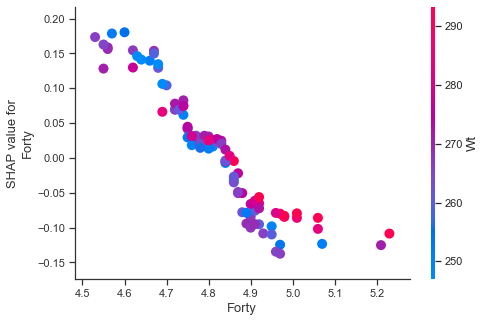

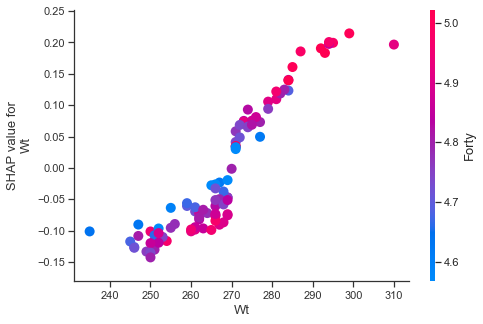

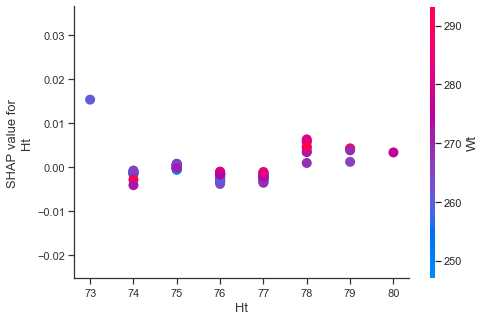

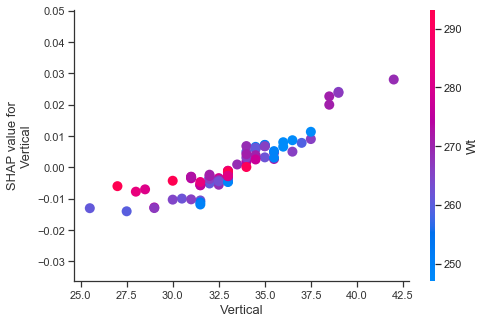

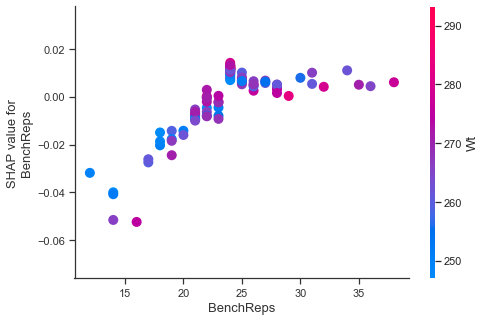

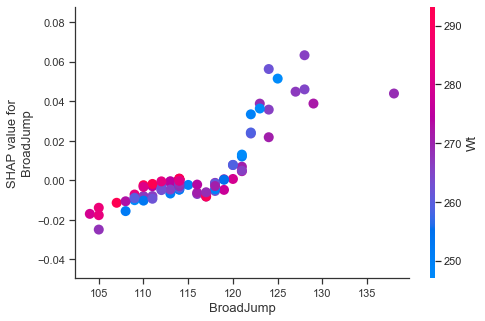

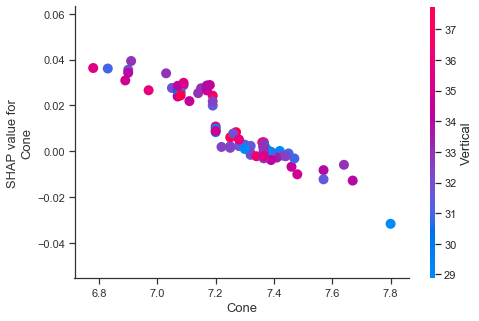

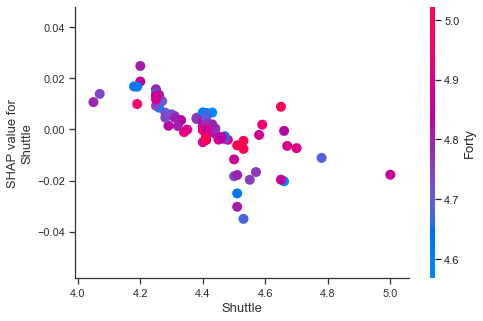

In [301]:
for feat in features:
    shap.dependence_plot(feat, test_shap_vals, test_X_imp_df, 
                         dot_size=100)

### Heatmap of SHAP values

In [305]:
test_shap_vals.shape

(96, 8)

In [308]:
y_test_and_pred_df

,true_AV_pctile,pred_AV_pctile
Player,,
Frank Alexander,0.621359,0.457392
Jake Bequette,0.002427,0.592134
Jamie Blatnick,0.002427,0.402816
Andre Branch,0.565534,0.538110
Quinton Coples,0.900485,0.586550
...,...,...
Ryan Russell,0.514563,0.412839
Preston Smith,0.900485,0.598127
Za'Darius Smith,0.669903,0.524560


In [309]:
# In the web version, the 'bias' column specified does not exist - rid of it
test_shap_df = pd.DataFrame(np.column_stack((test_shap_vals, y_test_and_pred_df)),
                            columns= features + ['true_AV_pctile', 
                                                 'pred_AV_pctile'])

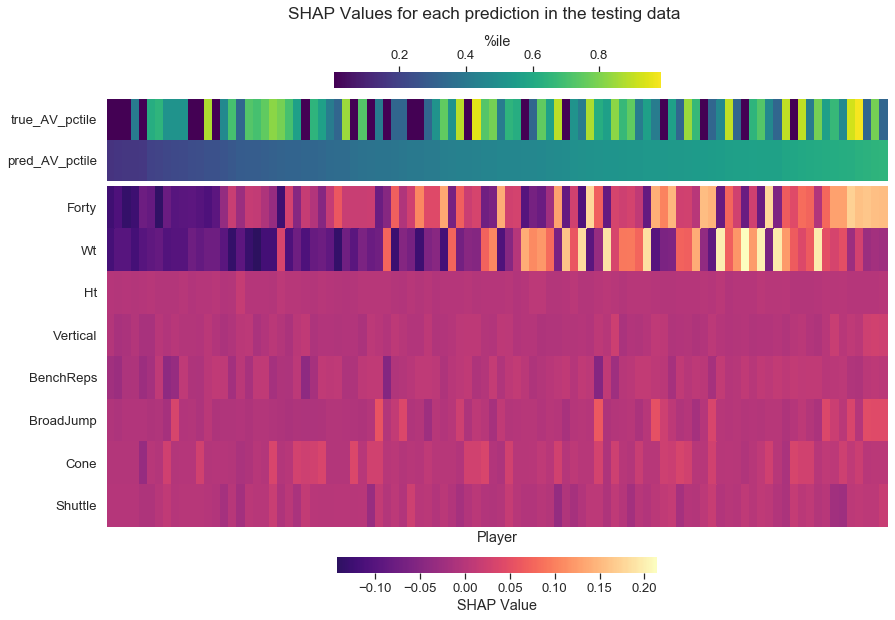

In [310]:
test_shap_df.sort_values('pred_AV_pctile', inplace=True)

title = 'SHAP Values for each prediction in the testing data'
fig = double_heatmap(test_shap_df[['true_AV_pctile', 'pred_AV_pctile']].T,
                     test_shap_df[features].T, '%ile', 'SHAP Value',
                     title=title, subplot_top=0.89)
fig.axes[1].set_xlabel('Player');

# **Appendix: Gini Impurity (With Examples)**

See https://bambielli.com/til/2017-10-29-gini-impurity/

# **NOT A GOOD SOURCE, KEEP IT FOR RECORD**

### Gini Impurity $G$
*a measurement of the likelihood of an incorrect classification of a new instance of a random variable, if that new instance were randomly classified according to the distribution of class labels from the data set.

$$G(k) = \sum_{i=1}^J(P_i(1-P_i)) $$

* $k$: task, 
* $i$: each class
* $J$: number of classes 
* $P_i$: probability of a class given the training data

In [ ]:
# Data array, specify columns
darray  = np.array([range(1,8), 
                    [1,0,1,0,0,1,0],
                    [1,1,0,0,0,1,0],
                    [0,1,1,0,0,0,1],
                    [1,0,1,0,1,1,0]
                   ])
# The array should specify values for each row
running = pd.DataFrame(np.transpose(darray),
                       columns=['Day', 'Weather', 'Ate', 'Late', 'Running'])
running

$$G(running) = P(Running = 1)(1-P(Running = 1)) + P(Running = 0)(1-P(Running = 1))$$

$$= \frac{4}{7}*(1-\frac{4}{7}) + \frac{3}{7}*(1-\frac{3}{7}) = 2*\frac{4}{7}*\frac{3}{7} = 0.49$$

### Gini gain

The formula does not make sense to me.

# **Appendix: Understanding Decision Tree Classification with Scikit-Learn**

See: https://towardsdatascience.com/understanding-decision-tree-classification-with-scikit-learn-2ddf272731bd

# Code outdated and does not work well

### Gini impurity

Definition
* Name after Italian statstician Corrado Gini
* $p(i|n)$: proporiotn of samples that belong to class k for node n
$$I_G = 1 - \sum_{i=1}^l p(i|n)^2$$

### Read data

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
bank_df = pd.read_csv('./data/bank.csv', delimiter = ';')
print(bank_df.head(3))

In [ ]:
attrib = list(bank_df.columns)
print(attrib)
print(len(attrib))

In [ ]:
# Some how the number is different from the web
print(bank_df.shape)

In [ ]:
# Instead of 'deposit', the data has the 'y' column indicating deposit, different from the web
sns.countplot(x = 'y', data = bank_df, palette = 'hls')
plt.xlabel('count', fontsize = 14)
plt.ylabel('deposit', fontsize = 14)
plt.show()

### One hot encoding with get_dummies()

In [ ]:
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']
bank_df_dummies = pd.get_dummies(bank_df, columns = cat_vars)
print(bank_df_dummies.head(3))

In [ ]:
attr2 = bank_df_dummies.columns.tolist()
print(attr2)
print(len(attr2))

### Specify label and features

In [ ]:
labels    = bank_df_dummies[['y']]
features = bank_df_dummies.drop(['y'], axis = 1)
print(labels.head(3))
print(features.head(3))

### Split training/testing

In [ ]:
from sklearn.model_selection import train_test_split

# Strategy: the proportion of values in the sample produced will be the same as 
# the proportion of values provided to this parameter
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size = 0.2, 
                                                    stratify = labels)
print(len(X_train))
print(len(X_test))

### Establish the pipeline

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
np.arange(3,15)

In [ ]:
## Here the estimator was decsT in the original doc, did not work
pipe_steps   = [('scaler', StandardScaler()),           # Standardize the features
                ('decsT', DecisionTreeClassifier())]
pipeline     = Pipeline(pipe_steps)

print(pipeline)

### Parameters to check

In [ ]:
RandomForestRegressor().get_params()

In [ ]:
# Check parameter for decision tree
DecisionTreeClassifier().get_params().keys()

In [ ]:
# The names for the parameters specified do not work, changed based on get_param()
check_params = {'criterion': ['gini', 'entropy'],
                'max_depth': np.arange(3,15)}     # Generate an array with 3-14

### Do 3, 4, 5 fold cv

In [ ]:
create_grid = GridSearchCV(pipeline, param_grid = check_params, cv = cv)

In [ ]:
create_grid.fit(X_train, y_train)

In [ ]:
from tqdm.notebook import tqdm

for cv in tqdm(range(3,6)):
    create_grid = GridSearchCV(pipeline, param_grid = check_params, cv = cv)
    create_grid.fit(X_train, y_train)
    print('Score for %i fold CV = %3.2f' % (cv, create_grid.score(X_test, y_test)))
    print('Best fit parameter:')
    print(create_grid.best_params_)

# **APPENDIX: pdpbox**


In [227]:
from pdpbox import pdp, get_dataset

test_titanic = get_dataset.titanic()
titanic_data = test_titanic['data']
titanic_target = test_titanic['target']
titanic_features = test_titanic['features']
titanic_model = test_titanic['xgb_model']

inter1 = pdp.pdp_interact(model=titanic_model,
                          dataset=titanic_data,
                          model_features=titanic_features,
                          features=['Age', 'Fare'],
                          num_grid_points=[10, 10],
                          percentile_ranges=[(5, 95), (5, 95)])
fig, axes = pdp.pdp_interact_plot(pdp_interact_out=inter1,
                                  feature_names=['age', 'fare'],
                                  plot_type='contour',
                                  x_quantile=True,
                                  plot_pdp=True)

XGBoostError: [14:55:17] C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:682: Check failed: header == serialisation_header_: 

  If you are loading a serialized model (like pickle in Python) generated by older
  XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version.  There's a simple script for helping
  the process. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for reference to the script, and more details about differences between saving model and
  serializing.

